In [0]:
access_key = dbutils.secrets.get(scope = 'aws', key = 'accessKey')
secret_key = dbutils.secrets.get(scope = 'aws', key = 'secretAccessKey')
sc._jsc.hadoopConfiguration().set('fs.s3a.access.key', access_key)
sc._jsc.hadoopConfiguration().set('fs.s3a.secret.key', secret_key)

In [0]:
# CSV paths
most_recent_csv_path = 's3://<BUCKET_NAME>/flights-csv/full-data/full-data-280k.csv' # all Ben's 26 operators, 6 airlines, has holiday, not dummiefied yet
# most_recent_csv_path = 's3://<BUCKET_NAME>/flights-csv/full-data/full-data.csv' # has only 79k rows, with 5 operators, 6 airlines, has a column for holiday => all these still need to be dummified
# most_recent_csv_path = 's3://<BUCKET_NAME>/flights-csv//2021-03-11-14-08/full-data.csv' # has about 500k rows, based on Ben's last parquet

def file_exists(path):
  try:
    dbutils.fs.ls(path)
    return True
  except Exception as e:
    if 'java.io.FileNotFoundException' in str(e):
      return False
    else:
      raise
      
import numpy as np
import pandas as pd

def pandas(dfSpark):
  # Enable Arrow-based columnar data transfers
  spark.conf.set("spark.sql.execution.arrow.enabled", "true")

  # Convert the Spark DataFrame to a Pandas DataFrame using Arrow
  return dfSpark.toPandas()

In [0]:
most_recent_parquet_path = 's3://<BUCKET_NAME>/flights-parquet//2021-03-11-11-10' # Ben - added flight duration
# most_recent_parquet_path = 's3://<BUCKET_NAME>/flights-parquet//2021-03-09-16-29' # added OtherDepartures column and filtered airports and weird flight times
# most_recent_parquet_path = 's3://<BUCKET_NAME>/flights-parquet//2021-03-07-00-00' # added RWT to original

#### Processing Base Data

In [0]:
def file_exists(path):
  try:
    dbutils.fs.ls(path)
    return True
  except Exception as e:
    if 'java.io.FileNotFoundException' in str(e):
      return False
    else:
      raise
      
print(file_exists(f's3://<BUCKET_NAME>/flights/{2020}-{11}-{31}')) # False
print(file_exists(f's3://<BUCKET_NAME>/flights/{2020}-{12}-{31}')) # True

# Write to parquet 
import pytz, datetime
def toParquet(data_frame, bucket='s3://<BUCKET_NAME>/flights-parquet/'):
  timestamp = datetime.datetime.utcnow().replace(tzinfo=pytz.utc).astimezone(pytz.timezone('US/Pacific')).strftime('%Y-%m-%d-%H-%M')
  last_run_parquet_path = f'{bucket}/{timestamp}'
  data_frame.write.parquet(last_run_parquet_path)
  print(f'Last run parquet path = \'{last_run_parquet_path}\'')
  assert file_exists(last_run_parquet_path), 'Check output name again'

False
True

In [0]:
# Oct - 31 days, Nov - 30 days, Dec 31 days => 31x3 + 30x3 + 31x3 = 276 days
df = spark.read.parquet('s3://<BUCKET_NAME>/flights/2020-12-01')

days_exist = [(2020, 12, 1)]
days_missing = []
for year in [2020, 2019, 2018]:
  for month in [12, 11, 10]:
    for day in range(1,32,1):
      if ((year, month, day) == (2020, 12, 1) or (month, day) == (11, 31)):
        continue
      path = f's3://<BUCKET_NAME>/flights/{year}-{month}-{day:02d}'
      if file_exists(path):
        days_exist.append((year, month, day))
        df_temp = spark.read.parquet(path)
        df = df.union(df_temp).dropDuplicates()
      else:
        days_missing.append((year, month, day))
        
print(f'Day count = {len(days_exist)}')
print(f'Missing days = {days_missing}')
print(f'Missing days count = {len(days_missing)}')

# Verify: Last run - 274 days => 1,698,787 flights         
df.count()

Day count = 274
Missing days = [(2020, 10, 26), (2020, 10, 27)]
Missing days count = 2
Out[3]: 1698787

In [0]:
import pyspark.sql.functions as F
# Expand LatLong columns, rename columns, select columns
df2 = df.withColumn('FromLat', df['DepartureLatLong'].getItem(0))\
       .withColumn('FromLong', df['DepartureLatLong'].getItem(1))\
       .withColumn('ToLat', df['ArrivalLatLong'].getItem(0))\
       .withColumn('ToLong', df['ArrivalLatLong'].getItem(1))\
       .withColumnRenamed('DepartureAirport', 'From')\
       .withColumnRenamed('ArrivalAirport', 'To')\
       .filter(F.col('Mil') == 0) \
       .filter(F.col('Species') == 1) \
       .select('Icao', 'Op', 'From', 'To', \
               'StartTime', 'LiftOffTime', \
               'TouchDownTime', 'StopTime', \
               'FromLat', 'FromLong', 'ToLat', 'ToLong') 

df2.count() # 1,554,307 flights

Out[4]: 1554307

In [0]:
# Write to csv using pipe "|" as delimiter 
# Because the Operator field sometimes has one or two commas in it to separate city and state
import pytz, datetime
def toCsv(data_frame, bucket='s3://<BUCKET_NAME>/flights-csv/'): # Spark data_frame
  timestamp = datetime.datetime.utcnow().replace(tzinfo=pytz.utc).astimezone(pytz.timezone('US/Pacific')).strftime('%Y-%m-%d-%H-%M')
  last_run_csv_path = f'{bucket}/{timestamp}'
  data_frame.repartition(1)\
          .write.format('com.databricks.spark.csv')\
          .option('header', 'true')\
          .option('delimiter', '|')\
          .save(last_run_csv_path)
  print(f'Last run csv path = \'{last_run_csv_path}\'')
  assert file_exists(last_run_csv_path), 'Check output name again'

In [0]:
from io import StringIO
import boto3

In [0]:
# Write to csv using pipe "|" as delimiter 
# Because the Operator field sometimes has one or two commas in it to separate city and state
from io import StringIO
import boto3
def toCsv2(df, folder, filename): # Pandas data frame
  csv_path = f's3://<BUCKET_NAME>/flights-csv/{folder}'
  
  csv_buffer = StringIO()
  df.to_csv(csv_buffer, sep='|', header=True)
  s3_resource = boto3.resource('s3')
  s3_resource.Object(csv_path, filename).put(Body=csv_buffer.getvalue())
  
  print(f'csv path = \'{csv_path}\'')
  assert file_exists(csv_path), 'Check output name again'

In [0]:
toParquet(df2)

Last run parquet path = 's3://runway-wait-time-data/flights-parquet//2021-03-06-23-14'

In [0]:
import numpy as np
import pandas as pd

def pandas(dfSpark):
  # Enable Arrow-based columnar data transfers
  spark.conf.set("spark.sql.execution.arrow.enabled", "true")

  # Convert the Spark DataFrame to a Pandas DataFrame using Arrow
  return dfSpark.toPandas()

In [0]:
# To convert Pandas DF to Spark DF
from pyspark.sql import SQLContext
def toSpark(pdDF):
  return SQLContext(sc).createDataFrame(pdDF)

#### Feature Eningeering

#### 1. Runway Wait Time (RWT)

In [0]:
dfRwt = spark.read.parquet(most_recent_parquet_path)
dfRwt.count() # Last run - 274 days => 1,554,307 flights

Out[3]: 1549282

In [0]:
# Check which columns have null values => only Op column has null values
dfpRwt = pandas(dfRwt)
dfpRwt.isnull().any()

Out[9]: Icao False
Op True
From False
To False
StartTime False
LiftOffTime False
TouchDownTime False
StopTime False
FromLat False
FromLong False
ToLat False
ToLong False
dtype: bool

In [0]:
# What flights have no Operator name
print(len(dfpRwt[dfpRwt.Op.isnull()]))
dfpRwt[dfpRwt.Op.isnull()].head()

27
Out[10]:

,Icao,Op,From,To,StartTime,LiftOffTime,TouchDownTime,StopTime,FromLat,FromLong,ToLat,ToLong
160696,A81183,None,OAK,OAK,2020-12-23 00:55:15.223,2020-12-23 21:31:59.150,2020-12-23 23:24:14.179,2020-12-23 23:26:55.336,37.661556,-122.124082,37.659818,-122.121441
191349,AAB698,None,PHX,PHX,2020-11-21 20:16:45.009,2020-11-21 20:41:13.947,2020-11-21 20:42:00.054,2020-11-21 20:42:00.054,33.425577,-112.020988,33.455882,-112.037906
198872,A05B45,None,SJC,SCK,2020-11-20 18:19:32.271,2020-11-20 18:21:44.757,2020-11-20 21:03:19.428,2020-11-20 21:46:00.076,37.330298,-121.815779,37.830791,-121.626731
385860,A05B45,None,NUQ,SCK,2020-11-20 17:02:02.070,2020-11-20 17:05:14.974,2020-11-20 17:28:30.031,2020-11-20 18:18:50.752,37.457291,-122.112277,37.830528,-121.626571
439843,ABD69E,None,ORL,ORL,2020-11-20 14:13:08.600,2020-11-20 14:26:59.439,2020-11-20 19:25:30.239,2020-11-20 14:12:00.527,28.547846,-81.337078,28.546938,-81.336149


In [0]:
dfpRwt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1554307 entries, 0 to 1554306
Data columns (total 12 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 Icao 1554307 non-null object 
 1 Op 1554280 non-null object 
 2 From 1554307 non-null object 
 3 To 1554307 non-null object 
 4 StartTime 1554307 non-null datetime64[ns]
 5 LiftOffTime 1554307 non-null datetime64[ns]
 6 TouchDownTime 1554307 non-null datetime64[ns]
 7 StopTime 1554307 non-null datetime64[ns]
 8 FromLat 1554307 non-null float64 
 9 FromLong 1554307 non-null float64 
 10 ToLat 1554307 non-null float64 
 11 ToLong 1554307 non-null float64 
dtypes: datetime64[ns](4), float64(4), object(4)
memory usage: 142.3+ MB

In [0]:
# Could add this to the preprocessing phase
import pyspark.sql.functions as F
dfRwt2 = dfRwt.withColumn('RunwayWaitTimeInSeconds', F.unix_timestamp(dfRwt.LiftOffTime) - F.unix_timestamp(dfRwt.StartTime))
dfNeg = dfRwt2.where('RunwayWaitTimeInSeconds < 0')
   
# Negative Runway Wait Time (RWT)
print(f'No. flights with negative RWT = {dfNeg.count()}') # 5025
print(f'% of flights with negative RWT = {round(dfNeg.count() * 100 / dfRwt2.count(), 2)}%') # 0.32%

No. flights with negative RWT = 5025
% of flights with negative RWT = 0.32%

In [0]:
dfNeg.select('Icao', 'Op', 'From', 'To', 'StartTime', 'LiftOffTime', 'RunwayWaitTimeInSeconds')\
     .where(F.col('From').isin({'SEA', 'LAX', 'SFO', 'DEN', 'DFW', 'ORD'}))\
     .show(100, truncate=False)

+------+-----------------------------------------------------------------------------------------------------------------------------------------+----+---+-----------------------+-----------------------+-----------------------+
Icao |Op |From|To |StartTime |LiftOffTime |RunwayWaitTimeInSeconds|
+------+-----------------------------------------------------------------------------------------------------------------------------------------+----+---+-----------------------+-----------------------+-----------------------+
A5225B|STATE FARM MUTUAL AUTOMOBILE INSURANCE CO - BLOOMINGTON, IL |SFO |COU|2019-11-18 21:01:34.206|2019-11-18 16:58:31.109|-14583 |
A7E1C2|FedEx |LAX |COU|2019-11-11 00:43:41.486|2019-11-10 08:12:28.706|-59473 |
A10785|United Express |ORD |TIK|2020-01-01 21:54:23.379|2019-12-31 00:00:05.829|-165258 |
A32EF8|JETBLUE AIRWAYS CORP - LONG ISLAND CITY, NY |ORD |ROC|2019-12-10 23:10:25.765|2019-12-09 00:50:31.019|-166794 |
A44262|DELTA AIR LINES INC - ATLANTA, GA |LAX |SEA|2019-12-02 22:11:14.412|2019-12-01 01:37:30.07 |-160424 |
AA3417|AMERICAN AIRLINES INC - FORT WORTH, TX |DFW |DFW|2020-12-24 03:46:27.977|2020-12-23 17:17:14.609|-37753 |
AAB001|UNITED AIRLINES INC - CHICAGO, IL |SFO |TLV|2019-12-31 13:43:23.602|2019-12-30 06:57:21.444|-110762 |
A97639|KALITTA AIR LLC - YPSILANTI, MI |LAX |SUU|2019-11-17 09:08:03.506|2019-11-17 00:23:31.26 |-31472 |
A54AB2|AIR WISCONSIN AIRLINES CORP - APPLETON, WI |ORD |BDL|2019-11-24 23:49:26.697|2019-11-23 00:00:32.6 |-172134 |
A7E579|FedEx |SEA |DAY|2019-11-16 14:48:29.046|2019-11-15 04:16:28.815|-124321 |
AD474C|Delta Air Lines |ORD |MSP|2019-12-22 21:55:24.658|2019-12-20 23:59:54.839|-165330 |
ACB468|American Eagle |ORD |ORD|2019-12-20 23:36:17.252|2019-12-19 00:00:11.787|-171366 |
A5625B|Alaska Airlines |SEA |BOI|2019-12-19 23:56:20.723|2019-12-17 23:59:51.578|-172589 |
A6F777|DELTA AIR LINES INC - ATLANTA, GA |LAX |GRF|2019-11-12 23:57:36.957|2019-11-11 00:18:32.393|-171544 |
A09E47|SkyWest Airlines |ORD |OKC|2019-11-25 23:52:39.221|2019-11-24 00:00:30.792|-172329 |
A04B92|SkyWest Airlines |SFO |SFO|2019-11-16 23:48:29.408|2019-11-15 00:00:30.602|-172079 |
A1512F|Alaska Airlines |SFO |FAT|2019-11-03 23:53:47.015|2019-11-02 00:00:31.434|-172396 |
AC3DDA|Consolidated Press Holdings Ltd |LAX |DRO|2019-12-17 20:45:23.819|2019-12-16 15:37:37.714|-104866 |
A2D38E|Alaska Airlines |SFO |SFO|2019-12-08 23:35:32.14 |2019-12-07 00:00:37.41 |-171295 |
AC9731|American Eagle |DFW |SPS|2019-12-28 22:00:41.158|2019-12-27 00:09:24.285|-165077 |
A7B92B|UNITED AIRLINES INC - CHICAGO, IL |SFO |PUB|2019-11-22 22:34:29.284|2019-11-21 04:41:31.249|-150778 |
A4200D|DELTA AIR LINES INC - ATLANTA, GA |LAX |LAX|2019-12-25 23:46:24.642|2019-12-24 00:06:22.895|-171602 |
A9A9EF|BEMIDJI AVIATION SERVICES INC - BEMIDJI, MN |DEN |DEN|2020-12-24 17:05:15.595|2020-12-23 14:36:59.479|-95296 |
A6AC39|Alaska Airlines |SEA |LAX|2019-12-20 04:57:22.596|2019-12-19 00:00:24.62 |-104218 |
A835D1|Alaska Airlines |SEA |SEA|2019-12-14 23:59:23.144|2019-12-13 00:28:43.396|-171040 |
A57362|Polar Air Cargo |LAX |ALB|2019-12-08 00:00:07.175|2019-12-06 01:21:48.789|-167899 |
A83F98|Alaska Airlines |SFO |HHR|2019-12-22 23:55:21.82 |2019-12-21 00:00:05.602|-172516 |
A0FBB7|United Airlines |SFO |DAY|2019-12-31 23:32:25.662|2019-12-30 00:00:24.545|-171121 |
A9250D|AMERICAN AIRLINES INC - FORT WORTH, TX |ORD |FMY|2019-11-15 22:23:59.248|2019-11-14 00:00:12.882|-167027 |
A041A6|United Express |ORD |MFE|2019-12-31 22:08:23.957|2019-12-30 00:34:27.134|-164036 |
A7D665|Compass Airlines |SEA |SJC|2019-12-11 22:16:30.373|2019-12-10 00:00:21.683|-166569 |
AA3839|American Eagle |ORD |MKE|2019-12-30 23:24:24.733|2019-12-29 01:01:23.622|-166981 |
A067EC|SkyWest Airlines |ORD |TYS|2019-11-27 22:31:54.444|2019-11-26 00:18:32.621|-166402 |
A96577|Delta Air Lines |SFO |IND|2019-12-28 23:26:22.944|2019-12-27 00:00:27.055|-170755 |
A2AF91|Delta Connection |LAX |OMA|2019-12-25 21:06:28.959|2019-12-24 00:01:32.714|-162296 |
A84ABD|Alaska Airlines

In [0]:
dfNeg.columns

Out[16]: ['Icao',
 'Op',
 'From',
 'To',
 'StartTime',
 'LiftOffTime',
 'TouchDownTime',
 'StopTime',
 'FromLat',
 'FromLong',
 'ToLat',
 'ToLong',
 'RunwayWaitTimeInSeconds']

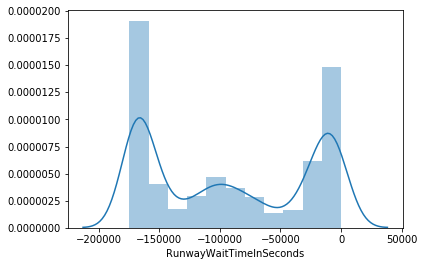

In [0]:
# Negative RWT 
import matplotlib.pyplot as plt
import seaborn as sns
'%matplotlib inline'
sns.distplot(pandas(dfNeg)['RunwayWaitTimeInSeconds'])
plt.show()

In [0]:
# df3 contains flights with non-negative RWT
dfRwt3 = dfRwt2.where('RunwayWaitTimeInSeconds >= 0')
assert dfRwt3.count() == dfRwt2.count() - dfNeg.count()

dfRwt3.count() # 1,549,282

Out[18]: 1549282

In [0]:
toParquet(dfRwt3)

Last run parquet path = 's3://runway-wait-time-data/flights-parquet//2021-03-07-00-00'

In [0]:
from pyspark.sql import functions as F
for hour in range(1,25):
  dfTemp = dfRwt3.where(F.col('RunwayWaitTimeInSeconds') > hour*3600)

  # Long Runway Wait Time (RWT)
  print(f'No. flights with RWT longer than {hour}h = {dfTemp.count()}')
  print(f'% flights with RWT longer than {hour}h = {round(dfTemp.count() * 100 / dfRwt3.count(), 2)}%')
  print()

No. flights with RWT longer than 1h = 403875
% flights with RWT longer than 1h = 26.07%

No. flights with RWT longer than 2h = 205132
% flights with RWT longer than 2h = 13.24%

No. flights with RWT longer than 3h = 152631
% flights with RWT longer than 3h = 9.85%

No. flights with RWT longer than 4h = 132924
% flights with RWT longer than 4h = 8.58%

No. flights with RWT longer than 5h = 122720
% flights with RWT longer than 5h = 7.92%

No. flights with RWT longer than 6h = 114983
% flights with RWT longer than 6h = 7.42%

No. flights with RWT longer than 7h = 105930
% flights with RWT longer than 7h = 6.84%

No. flights with RWT longer than 8h = 94791
% flights with RWT longer than 8h = 6.12%

No. flights with RWT longer than 9h = 81621
% flights with RWT longer than 9h = 5.27%

No. flights with RWT longer than 10h = 68069
% flights with RWT longer than 10h = 4.39%

No. flights with RWT longer than 11h = 54750
% flights with RWT longer than 11h = 3.53%

No. flights with RWT longer than 12h = 42164
% flights with RWT longer than 12h = 2.72%

No. flights with RWT longer than 13h = 30424
% flights with RWT longer than 13h = 1.96%

No. flights with RWT longer than 14h = 21409
% flights with RWT longer than 14h = 1.38%

No. flights with RWT longer than 15h = 14825
% flights with RWT longer than 15h = 0.96%

No. flights with RWT longer than 16h = 9973
% flights with RWT longer than 16h = 0.64%

No. flights with RWT longer than 17h = 6717
% flights with RWT longer than 17h = 0.43%

No. flights with RWT longer than 18h = 4435
% flights with RWT longer than 18h = 0.29%

No. flights with RWT longer than 19h = 2763
% flights with RWT longer than 19h = 0.18%

No. flights with RWT longer than 20h = 1745
% flights with RWT longer than 20h = 0.11%

No. flights with RWT longer than 21h = 1007
% flights with RWT longer than 21h = 0.06%

No. flights with RWT longer than 22h = 544
% flights with RWT longer than 22h = 0.04%

No. flights with RWT longer than 23h = 350
% flights with RWT longer than 23h = 0.02%

No. flights with RWT longer than 24h = 272
% flights with RWT longer than 24h = 0.02%

#### 2. Add Airport Traffic/Congestion

In [0]:
testDf = spark.read.parquet(most_recent_parquet_path)

In [0]:
testDf.show(5)

+------+--------------------+----+---+--------------------+--------------------+--------------------+--------------------+---------+-----------+---------+-----------+-----------------------+
 Icao| Op|From| To| StartTime| LiftOffTime| TouchDownTime| StopTime| FromLat| FromLong| ToLat| ToLong|RunwayWaitTimeInSeconds|
+------+--------------------+----+---+--------------------+--------------------+--------------------+--------------------+---------+-----------+---------+-----------+-----------------------+
A54DAD|BANK OF UTAH TRUS...| PHX|PHX|2018-10-31 12:57:...|2018-10-31 12:57:...|2018-10-31 12:58:...|2018-10-31 12:58:...|33.459374|-111.725772|33.459374|-111.725772| 6|
A131E1| Private| PHX|PHX|2018-10-31 19:50:...|2018-10-31 19:58:...|2018-10-31 19:58:...|2018-10-31 20:03:...|33.617729|-111.918694| 33.61805|-111.918526| 509|
A11FC7| United Airlines| SAN|NXX|2018-10-31 02:53:...|2018-10-31 04:23:...|2018-10-31 08:21:...|2018-10-31 08:34:...|32.734474|-117.203522|40.850008| -75.765901| 5404|
A54D69|BANK OF UTAH TRUS...| PHX|PHX|2018-10-31 17:00:...|2018-10-31 17:00:...|2018-10-31 17:01:...|2018-10-31 17:03:...|33.461769|-111.723074|33.462078|-111.723061| 1|
A5CE02| United Airlines| LGA|OMA|2018-10-31 00:45:...|2018-10-31 14:33:...|2018-10-31 17:18:...|2018-10-31 17:27:...|40.776886| -73.872131|41.144958| -95.34716| 49681|
+------+--------------------+----+---+--------------------+--------------------+--------------------+--------------------+---------+-----------+---------+-----------+-----------------------+
only showing top 5 rows

In [0]:
from datetime import timedelta
from pyspark.sql.types import *
from pyspark.sql import functions as F

# define UDF based on OP's function
TIME_DELTA = 30 # take plus/minus 30 minutes from start time
addDelta = (F.udf(lambda dt:  dt + timedelta(minutes=TIME_DELTA),
                TimestampType()))
subtractDelta = (F.udf(lambda dt:  dt - timedelta(minutes=TIME_DELTA),
                TimestampType()))

# now apply to timestamp columns
deltaDf = testDf.withColumn('DeltaWindowStart', subtractDelta(testDf['StartTime']))\
                .withColumn('DeltaWindowEnd', addDelta(testDf['StartTime']))
                            
deltaDf.show(5, truncate=False)

+------+---------------------------------------------+----+---+-----------------------+-----------------------+-----------------------+-----------------------+---------+-----------+---------+-----------+-----------------------+-----------------------+-----------------------+
Icao |Op |From|To |StartTime |LiftOffTime |TouchDownTime |StopTime |FromLat |FromLong |ToLat |ToLong |RunwayWaitTimeInSeconds|DeltaWindowStart |DeltaWindowEnd |
+------+---------------------------------------------+----+---+-----------------------+-----------------------+-----------------------+-----------------------+---------+-----------+---------+-----------+-----------------------+-----------------------+-----------------------+
A54DAD|BANK OF UTAH TRUSTEE - SALT LAKE CITY, UT|PHX |PHX|2018-10-31 12:57:24.826|2018-10-31 12:57:30.474|2018-10-31 12:58:34.013|2018-10-31 12:58:34.013|33.459374|-111.725772|33.459374|-111.725772|6 |2018-10-31 12:27:24.826|2018-10-31 13:27:24.826|
A131E1|Private |PHX |PHX|2018-10-31 19:50:18.044|2018-10-31 19:58:47.308|2018-10-31 19:58:49.488|2018-10-31 20:03:44.064|33.617729|-111.918694|33.61805 |-111.918526|509 |2018-10-31 19:20:18.044|2018-10-31 20:20:18.044|
A11FC7|United Airlines |SAN |NXX|2018-10-31 02:53:26.829|2018-10-31 04:23:30.551|2018-10-31 08:21:34.84 |2018-10-31 08:34:19.322|32.734474|-117.203522|40.850008|-75.765901 |5404 |2018-10-31 02:23:26.829|2018-10-31 03:23:26.829|
A54D69|BANK OF UTAH TRUSTEE - SALT LAKE CITY, UT|PHX |PHX|2018-10-31 17:00:19.708|2018-10-31 17:00:20.043|2018-10-31 17:01:54.051|2018-10-31 17:03:28.044|33.461769|-111.723074|33.462078|-111.723061|1 |2018-10-31 16:30:19.708|2018-10-31 17:30:19.708|
A5CE02|United Airlines |LGA |OMA|2018-10-31 00:45:32.387|2018-10-31 14:33:33.581|2018-10-31 17:18:12.466|2018-10-31 17:27:31.438|40.776886|-73.872131 |41.144958|-95.34716 |49681 |2018-10-31 00:15:32.387|2018-10-31 01:15:32.387|
+------+---------------------------------------------+----+---+-----------------------+-----------------------+-----------------------+-----------------------+---------+-----------+---------+-----------+-----------------------+-----------------------+-----------------------+
only showing top 5 rows

In [0]:
# create column that indicates the day on which the flight occurred in order to reduce the number of flights that need to be searched for airport congestion. Note that this would result in missing flights that span multiple days but greatly improve performance of this section
deltaDfWithDate = deltaDf.withColumn('DateIndicator', F.to_date(F.col('StartTime')))
deltaDfWithDate.show(5)

+------+--------------------+----+---+--------------------+--------------------+--------------------+--------------------+---------+-----------+---------+-----------+-----------------------+--------------------+--------------------+-------------+
 Icao| Op|From| To| StartTime| LiftOffTime| TouchDownTime| StopTime| FromLat| FromLong| ToLat| ToLong|RunwayWaitTimeInSeconds| DeltaWindowStart| DeltaWindowEnd|DateIndicator|
+------+--------------------+----+---+--------------------+--------------------+--------------------+--------------------+---------+-----------+---------+-----------+-----------------------+--------------------+--------------------+-------------+
A54DAD|BANK OF UTAH TRUS...| PHX|PHX|2018-10-31 12:57:...|2018-10-31 12:57:...|2018-10-31 12:58:...|2018-10-31 12:58:...|33.459374|-111.725772|33.459374|-111.725772| 6|2018-10-31 12:27:...|2018-10-31 13:27:...| 2018-10-31|
A131E1| Private| PHX|PHX|2018-10-31 19:50:...|2018-10-31 19:58:...|2018-10-31 19:58:...|2018-10-31 20:03:...|33.617729|-111.918694| 33.61805|-111.918526| 509|2018-10-31 19:20:...|2018-10-31 20:20:...| 2018-10-31|
A11FC7| United Airlines| SAN|NXX|2018-10-31 02:53:...|2018-10-31 04:23:...|2018-10-31 08:21:...|2018-10-31 08:34:...|32.734474|-117.203522|40.850008| -75.765901| 5404|2018-10-31 02:23:...|2018-10-31 03:23:...| 2018-10-31|
A54D69|BANK OF UTAH TRUS...| PHX|PHX|2018-10-31 17:00:...|2018-10-31 17:00:...|2018-10-31 17:01:...|2018-10-31 17:03:...|33.461769|-111.723074|33.462078|-111.723061| 1|2018-10-31 16:30:...|2018-10-31 17:30:...| 2018-10-31|
A5CE02| United Airlines| LGA|OMA|2018-10-31 00:45:...|2018-10-31 14:33:...|2018-10-31 17:18:...|2018-10-31 17:27:...|40.776886| -73.872131|41.144958| -95.34716| 49681|2018-10-31 00:15:...|2018-10-31 01:15:...| 2018-10-31|
+------+--------------------+----+---+--------------------+--------------------+--------------------+--------------------+---------+-----------+---------+-----------+-----------------------+--------------------+--------------------+-------------+
only showing top 5 rows

In [0]:
# deltaDfJoined contains column FlightsWithSameDepartureAirport that contains a list of all flights with the same From airport on the same date
deltaDfGroupedByFrom = deltaDfWithDate.withColumn('combined', F.struct(deltaDfWithDate.columns)).groupBy('From', 'DateIndicator').agg(F.collect_list('combined')).withColumnRenamed('collect_list(combined)', 'FlightsWithSameDepartureAirport')
deltaDfJoined = deltaDfWithDate.join(deltaDfGroupedByFrom, on=['From', 'DateIndicator'], how='inner')
deltaDfJoined.show(5)

+----+-------------+------+------------------+---+--------------------+--------------------+--------------------+--------------------+---------+-----------+---------+-----------+-----------------------+--------------------+--------------------+-------------------------------+
From|DateIndicator| Icao| Op| To| StartTime| LiftOffTime| TouchDownTime| StopTime| FromLat| FromLong| ToLat| ToLong|RunwayWaitTimeInSeconds| DeltaWindowStart| DeltaWindowEnd|FlightsWithSameDepartureAirport|
+----+-------------+------+------------------+---+--------------------+--------------------+--------------------+--------------------+---------+-----------+---------+-----------+-----------------------+--------------------+--------------------+-------------------------------+
 ABQ| 2018-10-06|ABF9D5|Southwest Airlines|DEN|2018-10-06 00:08:...|2018-10-06 01:24:...|2018-10-06 02:14:...|2018-10-06 13:49:...|35.047806|-106.614761|39.874935| -104.68708| 4577|2018-10-05 23:38:...|2018-10-06 00:38:...| [[ABF9D5, Southwe...|
 ABQ| 2018-10-06|A35DA8| Frontier Airlines|DEN|2018-10-06 20:54:...|2018-10-06 21:04:...|2018-10-06 21:54:...|2018-10-06 22:10:...|35.048344|-106.618011|39.903416|-104.696106| 587|2018-10-06 20:24:...|2018-10-06 21:24:...| [[ABF9D5, Southwe...|
 ABQ| 2018-10-06|A817B1| Alaska Airlines|SEA|2018-10-06 00:56:...|2018-10-06 01:03:...|2018-10-06 14:11:...|2018-10-06 16:37:...|35.046268|-106.618736|47.454208|-122.316662| 420|2018-10-06 00:26:...|2018-10-06 01:26:...| [[ABF9D5, Southwe...|
 ABQ| 2018-10-06|A8E75F| FedEx|LBB|2018-10-06 11:33:...|2018-10-06 13:18:...|2018-10-06 14:05:...|2018-10-06 14:09:...|35.031712|-106.623817| 33.66552|-101.828926| 6286|2018-10-06 11:03:...|2018-10-06 12:03:...| [[ABF9D5, Southwe...|
 ABQ| 2018-10-06|A82A44| Alaska Airlines|SEA|2018-10-06 02:19:...|2018-10-06 02:24:...|2018-10-06 05:17:...|2018-10-06 12:38:...|35.046284| -106.6185|47.449127|-122.318018| 304|2018-10-06 01:49:...|2018-10-06 02:49:...| [[ABF9D5, Southwe...|
+----+-------------+------+------------------+---+--------------------+--------------------+--------------------+--------------------+---------+-----------+---------+-----------+-----------------------+--------------------+--------------------+-------------------------------+
only showing top 5 rows

In [0]:
@udf(returnType=IntegerType())
def getAirportCongestion(flightList, startTime, endTime, icao):
  otherFlights = 0
  for flight in flightList:
    # if flight is at same time as query flight and is not the same flight (same ICAO), increment number of other flights 
    if flight['StartTime'] < endTime and flight['StartTime'] > startTime and flight['Icao'] != icao:
      otherFlights = otherFlights + 1 
  return otherFlights

In [0]:
congestionDf = deltaDfJoined.withColumn('OtherDepartures', getAirportCongestion(F.col('FlightsWithSameDepartureAirport'), F.col('DeltaWindowStart'), F.col('DeltaWindowEnd'), F.col('Icao'))) 
congestionDf.show(5)

+----+-------------+------+------------------+---+--------------------+--------------------+--------------------+--------------------+---------+-----------+---------+-----------+-----------------------+--------------------+--------------------+-------------------------------+---------------+
From|DateIndicator| Icao| Op| To| StartTime| LiftOffTime| TouchDownTime| StopTime| FromLat| FromLong| ToLat| ToLong|RunwayWaitTimeInSeconds| DeltaWindowStart| DeltaWindowEnd|FlightsWithSameDepartureAirport|OtherDepartures|
+----+-------------+------+------------------+---+--------------------+--------------------+--------------------+--------------------+---------+-----------+---------+-----------+-----------------------+--------------------+--------------------+-------------------------------+---------------+
 ABQ| 2018-10-06|ABF9D5|Southwest Airlines|DEN|2018-10-06 00:08:...|2018-10-06 01:24:...|2018-10-06 02:14:...|2018-10-06 13:49:...|35.047806|-106.614761|39.874935| -104.68708| 4577|2018-10-05 23:38:...|2018-10-06 00:38:...| [[ABF9D5, Southwe...| 0|
 ABQ| 2018-10-06|A35DA8| Frontier Airlines|DEN|2018-10-06 20:54:...|2018-10-06 21:04:...|2018-10-06 21:54:...|2018-10-06 22:10:...|35.048344|-106.618011|39.903416|-104.696106| 587|2018-10-06 20:24:...|2018-10-06 21:24:...| [[ABF9D5, Southwe...| 0|
 ABQ| 2018-10-06|A817B1| Alaska Airlines|SEA|2018-10-06 00:56:...|2018-10-06 01:03:...|2018-10-06 14:11:...|2018-10-06 16:37:...|35.046268|-106.618736|47.454208|-122.316662| 420|2018-10-06 00:26:...|2018-10-06 01:26:...| [[ABF9D5, Southwe...| 1|
 ABQ| 2018-10-06|A8E75F| FedEx|LBB|2018-10-06 11:33:...|2018-10-06 13:18:...|2018-10-06 14:05:...|2018-10-06 14:09:...|35.031712|-106.623817| 33.66552|-101.828926| 6286|2018-10-06 11:03:...|2018-10-06 12:03:...| [[ABF9D5, Southwe...| 1|
 ABQ| 2018-10-06|A82A44| Alaska Airlines|SEA|2018-10-06 02:19:...|2018-10-06 02:24:...|2018-10-06 05:17:...|2018-10-06 12:38:...|35.046284| -106.6185|47.449127|-122.318018| 304|2018-10-06 01:49:...|2018-10-06 02:49:...| [[ABF9D5, Southwe...| 1|
+----+-------------+------+------------------+---+--------------------+--------------------+--------------------+--------------------+---------+-----------+---------+-----------+-----------------------+--------------------+--------------------+-------------------------------+---------------+
only showing top 5 rows

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
'%matplotlib inline'
congestionDf.where(F.col('RunwayWaitTimeInSeconds') < 10000).limit(1000).toPandas().plot.scatter(x='OtherDepartures', y='RunwayWaitTimeInSeconds')
plt.show()

##### Filtering Airports

In [0]:
# 15 biggest and busiest airports in the US + 11 other notables
airportList = ['LAX', 'ATL', 'ORD', 'DFW', 'DEN', 'JFK', 'SFO', 'LAS', 'SEA', 'CLT', 'MCO', 'MIA', 'PHX', 'EWR', 'IAH', 'DTW', 'IAD', 'MSP', 'LGA', 'PDX', 'TPA', 'BOS', 'SLC', 'PHL', 'FLL', 'MDW']

In [0]:
congestionDfFilteredByAirport = congestionDf.filter(F.col('From').isin(airportList))
congestionDfFilteredByAirport.count() # 854,446

Out[18]: 854446

##### Filtering Unreasonable Flight Times

In [0]:
# look at flight times
import pyspark.sql.functions as F
df2 = congestionDfFilteredByAirport.withColumn('FlightDuration', F.unix_timestamp(congestionDfFilteredByAirport.TouchDownTime) - F.unix_timestamp(congestionDfFilteredByAirport.LiftOffTime))
df2.select('FlightDuration').describe().show()

+-------+------------------+
summary| FlightDuration|
+-------+------------------+
 count| 854446|
 mean| 6213.572851882975|
 stddev|15728.875402249041|
 min| -172561|
 max| 166800|
+-------+------------------+

In [0]:
# we have flights ranging from negative values to 47 hours long - needs filtering!
# min = 15 mins = 900 seconds
# max = 19 hours = 68,400 seconds
df3 = df2.filter( (F.col('FlightDuration') > 900) & (F.col('FlightDuration') < 68400) )
df3.count() #557,701

Out[25]: 557701

In [0]:
df3.columns

Out[26]: ['From',
 'DateIndicator',
 'Icao',
 'Op',
 'To',
 'StartTime',
 'LiftOffTime',
 'TouchDownTime',
 'StopTime',
 'FromLat',
 'FromLong',
 'ToLat',
 'ToLong',
 'RunwayWaitTimeInSeconds',
 'DeltaWindowStart',
 'DeltaWindowEnd',
 'FlightsWithSameDepartureAirport',
 'OtherDepartures',
 'FlightDuration']

In [0]:
colsToDrop = ('DateIndicator', 'DeltaWindowStart', 'DeltaWindowEnd', 'FlightsWithSameDepartureAirport')
df4 = df3.drop(*colsToDrop)

In [0]:
df4.columns

Out[28]: ['From',
 'Icao',
 'Op',
 'To',
 'StartTime',
 'LiftOffTime',
 'TouchDownTime',
 'StopTime',
 'FromLat',
 'FromLong',
 'ToLat',
 'ToLong',
 'RunwayWaitTimeInSeconds',
 'OtherDepartures',
 'FlightDuration']

In [0]:
toParquet(df4)

Last run parquet path = 's3://runway-wait-time-data/flights-parquet//2021-03-11-11-10'

#### 3. Getting weather data

In [0]:
%pip install meteostat

Python interpreter will be restarted.
Collecting meteostat
 Downloading meteostat-1.1.1.tar.gz (11 kB)
Collecting pandas>=1.1
 Downloading pandas-1.2.3-cp37-cp37m-manylinux1_x86_64.whl (9.9 MB)
Requirement already satisfied: pytz in /databricks/python3/lib/python3.7/site-packages (from meteostat) (2019.3)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.7/site-packages (from meteostat) (1.18.1)
Requirement already satisfied: python-dateutil>=2.7.3 in /databricks/python3/lib/python3.7/site-packages (from pandas>=1.1->meteostat) (2.8.1)
Requirement already satisfied: six>=1.5 in /databricks/python3/lib/python3.7/site-packages (from python-dateutil>=2.7.3->pandas>=1.1->meteostat) (1.14.0)
Building wheels for collected packages: meteostat
 Building wheel for meteostat (setup.py): started
 Building wheel for meteostat (setup.py): finished with status 'done'
 Created wheel for meteostat: filename=meteostat-1.1.1-py3-none-any.whl size=15528 sha256=cdb1dcc6fa76a3a0c81d0fa2ff4e31918e971ceb2d7284e1ae71f1b71c32b960
 Stored in directory: /home/root/.cache/pip/wheels/21/b0/11/b84ba37a06a41e37e26d99147327fb32af1662bf9b366dc616
Successfully built meteostat
Installing collected packages: pandas, meteostat
 Attempting uninstall: pandas
 Found existing installation: pandas 1.0.1
 Not uninstalling pandas at /databricks/python3/lib/python3.7/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-4eb309b9-8291-4ddf-a7d5-a4ddd9d29904
 Can't uninstall 'pandas'. No files were found to uninstall.
Successfully installed meteostat-1.1.1 pandas-1.2.3
Python interpreter will be restarted.

In [0]:
# Example
# Import Meteostat library and dependencies
from datetime import datetime
from meteostat import Point, Hourly

# Set time period
start = datetime(2020, 12, 31, 5, 36)
end = datetime(2020, 12, 31, 6, 37)

# Get hourly data
data = Hourly(Point(39.864498, -104.687622), start, end)
data = data.fetch()

# Print DataFrame
data.reset_index().to_dict('list')

Out[1]: {'time': [Timestamp('2020-12-31 06:00:00')],
 'temp': [-3.6],
 'dwpt': [-11.9],
 'rhum': [52.9],
 'prcp': [0.0],
 'snow': [nan],
 'wdir': [340.0],
 'wspd': [9.3],
 'wpgt': [nan],
 'pres': [1018.6],
 'tsun': [nan],
 'coco': [2.0]}

In [0]:
# AC1E56	FedEx	OAK	OAK	2018-12-31 05:36:35.721	2018-12-31 05:36:51.373	2018-12-31 05:37:15.593	2018-12-31 05:37:15.593	1	False	37.716611	-122.221408	37.716611	-122.221408
from datetime import datetime, timedelta
from meteostat import Point, Daily
import math

def weather(startTime, liftOffTime, lat, long): 
  # for now, assume if it spans multiple hours => use weather data from the first hour
  start, end = startTime, liftOffTime # assume startTime < liftOffTime
  start = start - timedelta(hours=1)
  end = start + timedelta(hours=1)
     
  location = Point(lat, long)

  data = Hourly(location, start, end)
  data = data.fetch()
  if len(data) > 1:
    result = data.reset_index().loc[[0]].to_dict('list')
  else:
    result = data.reset_index().to_dict('list')
  
  if (len(result['temp']) > 0 and result['temp'][0]):
    result['temp'][0] = round((result['temp'][0] * 1.8) + 32, 2)
  
  for var in ['snow', 'wpgt', 'tsun']:
    if (len(result[var]) > 0 and math.isnan(result[var][0])):
      result[var][0] = 0.0

  #  Make sure the scheme data type for ConditionCode match as well. Either DoubleType or StringType
  condition_codes = {1: 'Clear', 2: 'Fair', 3: 'Cloudy', \
                     4:	'Overcast', 5: 'Fog', 6: 'Freezing Fog', \
                     7:	'Light Rain', 8: 'Rain', 9:	'Heavy Rain', \
                     10: 'Freezing Rain', 11: 'Heavy Freezing Rain', \
                     12: 'Sleet', 13: 'Heavy Sleet', 14: 'Light Snowfall', \
                     15: 'Snowfall', 16: 'Heavy Snowfall', 17: 'Rain Shower', \
                     18: 'Heavy Rain Shower', 19: 'Sleet Shower', 20: 'Heavy Sleet Shower', \
                     21: 'Snow Shower', 22: 'Heavy Snow Shower', 23: 'Lightning', \
                     24: 'Hail', 25: 'Thunderstorm', 26: 'Heavy Thunderstorm', 27: 'Storm'}
  
  if ( (len(result['coco']) > 0) and (not math.isnan(result['coco'][0])) ):
    if int(result['coco'][0]) in condition_codes:
      result['coco'][0] = condition_codes[int(result['coco'][0])]
    else:
      result['coco'][0] = 'Unknown'
    
  keys = ['time', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'coco']
  results = [result[key][0] if (key in result and len(result[key]) > 0) else None for key in keys]
  return results
#   return {keys[i] : results[i] for i in range(len(keys))}

#   return result

weather(datetime(2018, 12, 31, 5, 0, 0), datetime(2018, 12, 31, 6, 7, 0, 16), 37.716611, -122.221408)  

Out[8]: [Timestamp('2018-12-31 04:00:00'),
 49.82,
 7.2,
 83.8,
 0.0,
 0.0,
 270.0,
 11.0,
 0.0,
 1017.3,
 0.0,
 'Cloudy']

In [0]:
dfWeather = spark.read.options(delimiter='|', inferSchema='True', header='True')\
                      .csv(most_recent_csv_path)
print(type(dfWeather))

<class 'pyspark.sql.dataframe.DataFrame'>

In [0]:
dfWeather.count() # 557,701

Out[8]: 557701

In [0]:
dfpWeather = pandas(dfWeather)
print(type(dfpWeather))

<class 'pandas.core.frame.DataFrame'>

In [0]:
len(dfpWeather)

Out[10]: 557701

In [0]:
dfpWeather.columns

Out[11]: Index(['From', 'Icao', 'Op', 'To', 'StartTime', 'LiftOffTime', 'TouchDownTime',
 'StopTime', 'FromLat', 'FromLong', 'ToLat', 'ToLong',
 'RunwayWaitTimeInSeconds', 'OtherDepartures', 'FlightDuration'],
 dtype='object')

In [0]:
dfpWeather.head()

Out[12]:

,From,Icao,Op,To,StartTime,LiftOffTime,TouchDownTime,StopTime,FromLat,FromLong,ToLat,ToLong,RunwayWaitTimeInSeconds,OtherDepartures,FlightDuration
0,ATL,A5427B,Delta Connection,MGE,2019-12-04 12:52:59.365,2019-12-04 12:52:59.365,2019-12-04 14:23:54.729,2019-12-04 17:23:59.988,33.631804,-84.411049,33.652496,-84.905371,0,0,5455
1,ATL,A3DF4A,Frontier Airlines,COS,2019-12-24 15:02:23.902,2019-12-24 16:31:20.110,2019-12-24 22:23:22.434,2019-12-24 22:30:22.430,33.645304,-84.406285,38.791700,-104.687912,5337,0,21122
2,ATL,A35283,Frontier Airlines,LAX,2019-12-24 13:24:22.657,2019-12-24 15:28:21.577,2019-12-24 19:32:52.881,2019-12-24 19:38:21.952,33.638030,-84.422350,33.936535,-118.390789,7439,0,14671
3,ATL,ABC573,Delta Air Lines,SFO,2019-12-24 00:06:22.204,2019-12-24 02:09:21.282,2019-12-24 06:46:17.404,2019-12-24 06:48:36.247,33.644024,-84.422336,37.621674,-122.376037,7379,1,16616
4,ATL,A13B66,JetBlue Airways,WAL,2019-12-24 00:34:21.210,2019-12-24 16:30:21.212,2019-12-24 17:47:38.693,2019-12-24 17:49:17.903,33.635777,-84.416773,38.068139,-75.513452,57360,1,4637


In [0]:
dfpWeather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557701 entries, 0 to 557700
Data columns (total 15 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 From 557701 non-null object 
 1 Icao 557701 non-null object 
 2 Op 557687 non-null object 
 3 To 557701 non-null object 
 4 StartTime 557701 non-null datetime64[ns]
 5 LiftOffTime 557701 non-null datetime64[ns]
 6 TouchDownTime 557701 non-null datetime64[ns]
 7 StopTime 557701 non-null datetime64[ns]
 8 FromLat 557701 non-null float64 
 9 FromLong 557701 non-null float64 
 10 ToLat 557701 non-null float64 
 11 ToLong 557701 non-null float64 
 12 RunwayWaitTimeInSeconds 557701 non-null int32 
 13 OtherDepartures 557701 non-null int32 
 14 FlightDuration 557701 non-null int32 
dtypes: datetime64[ns](4), float64(4), int32(3), object(4)
memory usage: 57.4+ MB

In [0]:
# Remove Op = None
dfpWeather2 = dfpWeather[dfpWeather['Op'].notnull()]
len(dfpWeather2)                         

Out[14]: 557687

In [0]:
# Delta Air Lines
# Alaska Airlines
# JetBlue Airways
# American Airlines
# Southwest Airlines
# United Airlines

In [0]:
# Delta 
dfpWeather2[dfpWeather2['Op'].str.upper().str.contains('DELTA')]['Op'].value_counts()

Out[16]: Delta Air Lines 44568
Delta Connection 18962
DELTA AIR LINES INC - ATLANTA, GA 10176
Delta Airlines 462
SkyWest Airlines (Delta Connection) 210
Skywest Delta Connection 187
Skywest Airlines (Delta Connection) 176
DELTA AIR LINES INC DEPT 595 AIRCRAFT REGISTRATIONS - ATLANTA, GA 146
Delta Private Jets 63
Delta Air Lines (SkyTeam Livery) 49
Endeavor Air (Delta Connection) 40
DELTA AIR LINES INC - ALLANTA, GA 36
DELTA AIR LINES INC DEPT 595 AIRCRAFT REGISTRATION - ATLANTA, GA 32
Endeavor Air Delta Connection 32
SkyWest (Delta Connection) 29
SkyWest Delta Connection 28
DELTA AIRLINES INC DEPT 595 AIRCRAFT REGISTRATIONS - ATLANTA, GA 25
Delta 15
Delta Connection (Endeavor Air) 14
Endeavor Air Delta Connection 9
NETJETS SALES INC COMET I LLC TRINITY AIR LLC GILLIS STRATTON DELTA PEGASUS MANAGEMENT LLC COTTRILL LANCE- OKLAHOMA CITY, OK 9
DELTA RIM INC - GREENVILLE, MS 6
DELTA AIR LINES - ATLANTA, GA 5
GoJet Delta Connection 5
CRAFTS LARRY Z - DELTA, UT 5
Delta Point LLC 3
DELTA JET LTD - SOMERVILLE, MA 2
DELTA LEASING LLC - NASHVILLE, TN 2
DELTA AIRLINES INC - ATLANTA, GA 2
NEW TECH MARKETING INTERNATIONAL INC JOBSIGHT DELTA INC - AURORA, IL 1
DELTA BRAVO LLC - LAS VEGAS, NV 1
Delta Southern Resource Leasing LLC 1
DELTA SIERRA LLC - FREMONT, NE 1
Delta Rim Inc 1
Delta Gaston Beta LLC 1
Delta Air lines 1
LOVE TO FLY AVIATION LLC DELTA-X AVIATION LLC NOLOGO AIR INC - HEALDSBURG, CA 1
Delta Investment Group LLC 1
Name: Op, dtype: int64

In [0]:
# Delta
valid_delta = ['Delta Air Lines', 'DELTA AIR LINES INC     - ATLANTA, GA', 'Delta Airlines']

condNotContainsDelta = ~(dfpWeather2['Op'].str.upper().str.contains('DELTA'))
condContainsValidDelta = dfpWeather2[dfpWeather2['Op'].str.upper().str.contains('DELTA')]['Op'].isin(valid_delta)

dfpWeather3 = dfpWeather2[condNotContainsDelta | condContainsValidDelta]

# dfpWeather3['Op'] = dfpWeather3['Op'].apply(lambda x: 'Delta Air Lines' if 'DELTA' in x.upper() else x)
dfpWeather3.loc[dfpWeather3['Op'].str.contains('delta', case=False), 'Op'] = 'Delta Air Lines'

len(dfpWeather3)

/databricks/python/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 self.obj[item] = s
Out[17]: 537586

In [0]:
dfpWeather3['Op']

Out[18]: 1 Frontier Airlines
2 Frontier Airlines
3 Delta Air Lines
4 JetBlue Airways
5 Delta Air Lines
 ... 
557696 JetBlue Airways
557697 Sun Country Airlines
557698 AFS INVESTMENTS 57 LLC - NORWALK, CT
557699 Spirit Airlines
557700 JetBlue Airways
Name: Op, Length: 537586, dtype: object

In [0]:
# Alaska: variants made up of only a very small fraction -> ignored
dfpWeather3[dfpWeather3['Op'].str.upper().str.contains('ALASKA')]['Op'].value_counts()

Out[19]: Alaska Airlines 30003
AIRCRAFT GUARANTY CORP TRUSTEE - ONALASKA, TX 225
ALASKA AIRLINES 173
Alaskan Airlines 48
Alaska Airlines (Salmon-Thirty-Salmon Livery) 45
Alaska Airlines (75th Anniv Livery) 42
MIDWEST NATIONAL SERVICES INC - ONALASKA, WI 7
WORTHINGTON FORD OF ALASKA INC - ANCHORAGE, AK 6
ALASKA AVIATION TOXICOLOGY INC - FAIRBANKS, AK 2
MDSFEST INC - ONALASKA, WI 1
Name: Op, dtype: int64

In [0]:
# Alaska
valid_alaska = ['Alaska Airlines']

condNotContainsAlaska = ~(dfpWeather3['Op'].str.contains('Alaska', case=False))
condContainsValidAlaska = dfpWeather3[dfpWeather3['Op'].str.contains('Alaska', case=False)]['Op'].isin(valid_alaska)

dfpWeather4 = dfpWeather3[condNotContainsAlaska | condContainsValidAlaska]
# dfpWeather4.loc[dfpWeather4['Op'].str.contains('alaska', case=False), 'Op'] = 'Alaska Airlines'

len(dfpWeather4)

Out[20]: 537037

In [0]:
# American
dfpWeather4[dfpWeather4['Op'].str.contains('American', case=False)]['Op'].value_counts()

Out[21]: American Airlines 76536
American Eagle 13320
AMERICAN AIRLINES INC - FORT WORTH, TX 7380
American Eagle - Envoy Air 3354
AMERICAN AIRLINES INC - FT WORTH, TX 515
Envoy Air (American Eagle) 260
American Airlines (Piedmont Heritage Livery) 129
AMERICAN AIRCRAFT & MARINE LLC - INDIANAPOLIS, IN 68
AMERICAN ACADEMY HOLDINGS INC - DOVER, DE 48
AMERICAN AIRLINES INC - DFW AIRPORT, TX 28
American Airlines (OneWorld Livery) 28
American Airpower Heritage Flying Museum 13
NETJETS SALES INC AMERICAN WARRIOR INC SHAW INDUSTRIES INC STEVE PARRISH CONSULTING GROUP LLC RAITT JOHN R GOLDSTEIN GROUP INC- OKLAHOMA CITY, OK 9
AMERICAN AIRPOWER HERITAGE FLY MUSEU - DALLAS, TX 9
AMERICAN AIRPOWER HERITAGE FLYING MUSEUM INC - DALLAS, TX 7
AMERICAN AIRPOWER HERITAGE FLYING MUSEUM - DALLAS, TX 7
AMERICAN AVIATION INC - SALT LAKE CITY, UT 6
AMERICAN EXPRESS TRAVEL RELATED SERVICE CO INC - NEWBURGH, NY 6
EQUITY AMERICAN FINANCIAL SERVICES INC HERDA LARISSA HERDA STEPHEN WELLS FARGO BANK NORTHWEST NA TRUSTEE GRINDSTONE MANAGEMENT LLC CROWN AVIATION INC- CLEVELAND, OH 4
AMERICAN CAREER COLLEGE INC C & A AVIATION LLC DARTBROOK PARTNERS LLC HASTAROTH LLC WEST COAST AVIATION SERVICES LLC WJL ENTERPRISES LLC- SANTA ANA, CA 4
NETJETS SALES INC BRAHMAN CAPITAL CORP CAMERON INTERNATIONAL CORP CLOVER AVIATION LLC TULLY DANIEL P EURO AMERICAN JETPLANE LLC- OKLAHOMA CITY, OK 4
AMERICAN INTERNATIONAL GROUP INC - TETERBORO, NJ 4
AMERICAN LUBRICANTS & CHEMICALS LLC - MARIETTA, OH 3
Aerownership North American Services Inc 3
NORTH AMERICAN FINANCIAL - WOODBURN, OR 3
Envoy Air (American Airlines) 3
NATIVE AMERICAN AIR SERVICE INC - ENGLEWOOD, CO 3
PSA Airlines (American Eagle) 3
AMERICAN AIRPOWER HERITAGE FLY MUSM - MIDLAND, TX 2
NETJETS SALES INC WEBBER DEVELOPMENT COMPANY LLC MICROSOFT FINANCING CORPORATION AMERICAN SECURITIES LLC MARQUIS JET HOLDINGS INC - OKLAHOMA CITY, OK 2
SIERRA AMERICAN CORP - WILMINGTON, DE 2
AMERICAN MINE RESEARCH INC - ROCKY GAP, VA 1
American Aviation Inc 1
American International Group Inc 1
AMERICAN AIRPLANE EXCHANGE DBA AMERICAN AIRCRAFT SALES - SANTA ANA, CA 1
NORTH AMERICAN AIR CHARTER CORP - OSTERVILLE, MA 1
AMERICAN FAMILY MUTUAL INSURANCE CO - MADISON, WI 1
AMERICAN BUILDERS & CONTRACTORS SUPPLY CO INC - BELOIT, WI 1
AMERICAN AIRPOWER HERITAGE FLYING - MIDLAND, TX 1
AMERICAN CAMPUS COMMUNITIES SERVICES INC - AUSTIN, TX 1
American Jet International 1
AMERICAN AIR CHARTER INC - BOCA RATON, FL 1
AMERICAN EQUITY INVESTMENT PROPERTIES LC - WEST DES MOINES, IA 1
American Electric Power Service Corp 1
American Express Travel Co 1
Name: Op, dtype: int64

In [0]:
# American
valid_american = ['American Airlines', 'AMERICAN AIRLINES INC     - FORT WORTH, TX']

condNotContainsAmerican = ~(dfpWeather4['Op'].str.contains('American', case=False))
condContainsValidAmerican = dfpWeather4[dfpWeather4['Op'].str.contains('American', case=False)]['Op'].isin(valid_american)

dfpWeather5 = dfpWeather4[condNotContainsAmerican | condContainsValidAmerican]
dfpWeather5.loc[dfpWeather5['Op'].str.contains('American', case=False), 'Op'] = 'American Airlines'

len(dfpWeather5)

Out[22]: 519176

In [0]:
# JetBlue: take all
dfpWeather5[dfpWeather5['Op'].str.contains('JetBlue', case=False)]['Op'].value_counts()

Out[23]: JetBlue Airways 18557
JETBLUE AIRWAYS CORP - LONG ISLAND CITY, NY 967
JetBlue 171
Name: Op, dtype: int64

In [0]:
# JetBlue
dfpWeather5.loc[dfpWeather5['Op'].str.contains('JetBlue', case=False), 'Op'] = 'JetBlue Airways'

len(dfpWeather5)

Out[24]: 519176

In [0]:
# Southwest: ignore all other variants
dfpWeather5[dfpWeather5['Op'].str.contains('Southwest', case=False)]['Op'].value_counts()

Out[25]: Southwest Airlines 46648
SOUTHWEST AIRLINES CO - DALLAS, TX 608
SouthWest Airlines 228
Southwest Airlines (Classic Gold Livery) 74
Southwest Airlines (Tennessee One Livery) 64
IMAGE AIR OF SOUTHWEST FLORIDA LLC - BLOOMINGTON, IL 61
Southwest Airlines (Shark Week Livery) 55
Southwest Airlines (Colorado One Livery) 46
Southwest Airlines (New Mexico One Livery) 32
Southwest Airlines (Nevada One Livery) 31
Southwest Airlines (Illinois One Livery) 22
SOUTHWEST GAS CORP - LAS VEGAS, NV 16
SOUTHWEST AVIATION SOLUTIONS LLC - LAS VEGAS, NV 16
WELLS FARGO BANK NORTHWEST NA TRUSTEE EMPIRE SOUTHWEST LLC FIS INC HEXAGON INC HURON TRAVEL LLC LINDQUIST PROPERTIES LLC- OKLAHOMA CITY, OK 13
Cutter Southwest Aircraft Sales LLC 8
CUTTER SOUTHWEST AIRCRAFT SALES LLC - PHOENIX, AZ 7
Southwest Aircraft Charter LC 2
CUTTER SOUTHWEST AIRCRFT SALES LLC - PHOENIX, AZ 2
Southwest Aviation Specialities LLC 1
SOUTHWEST AVIATION SPECIALTIES LLC - TULSA, OK 1
SOUTHWEST AIRCRAFT CHARTER LC - MESA, AZ 1
Name: Op, dtype: int64

In [0]:
# Southwest
valid_southwest = ['Southwest Airlines']

condNotContainsSouthwest = ~(dfpWeather5['Op'].str.contains('Southwest', case=False))
condContainsValidSouthwest = dfpWeather5[dfpWeather5['Op'].str.contains('Southwest', case=False)]['Op'].isin(valid_southwest)

dfpWeather6 = dfpWeather5[condNotContainsSouthwest | condContainsValidSouthwest]
dfpWeather6.loc[dfpWeather6['Op'].str.contains('Southwest', case=False), 'Op'] = 'Southwest Airlines'

len(dfpWeather6)

Out[26]: 517888

In [0]:
# United: ignore all other variants
dfpWeather6[dfpWeather6['Op'].str.contains('United', case=False)]['Op'].value_counts()

Out[27]: United Airlines 45766
United Express 11498
United Parcel Service 7142
UNITED AIRLINES INC - CHICAGO, IL 2222
SkyWest Airlines (United Express) 181
UNITED AIRLINES INC ATTN: TREASURER - CHICAGO, IL 68
UNITED PARCEL SERVICE CO - LOUISVILLE, KY 67
UNITED FLYING CLUB INC - BELMONT, CA 50
United Airliens 50
United Express CommutAir 29
United Express - GoJet 13
United Healthcare Services 9
United States Dept of Commerce (NOAA) 6
United Group Aviation LLC 4
UNITED STATES DEPARTMENT OF COMMERCE - MCADILL AFB, FL 3
NETJETS SALES INC HUNT AVIATION SERVICES LLC UNITED DISTRIBUTORS INC STEERS ROBERT H 3JC CORP CAC ENTERPRISES LLC- OKLAHOMA CITY, OK 3
UNITED TECHNOLOGIES CORP - HARTFORD, CT 3
UNITED SERVICES AUTOMOBLIE ASSOCIATION 2
UNITED HEALTHCARE SERVICES INC - LATROBE, PA 1
United States Department of Interior 1
United States Marshals Service 1
PEOPLES UNITED BANK AFFILIATED MANAGERS GROUP INC KAPLAN ROBERT S MURRAY STEPHEN B DBA MURRAY LAW FIRM ZIFF BROTHERS INVESTMENTS LLC 1530 MANAGEMENT LLC- PORTSMOUTH, NH 1
EXECUTIVE AIRSHARE CORP UNITED STATES BEEF CORP ALLRED AIRCRAFT LLC JONES DEVELOPMENT CO LLC JACKSON AIRCRAFT LLC - WICHITA, KS 1
UNITED STATES AIR FORCE OWNER PETERSON AERO CLUB - OPERATOR - COLORADO SPRINGS, CO 1
UNITED AERONAUTICAL CORP - NORTH HOLLYWOOD, CA 1
UNITED GROUP AVIATION LLC - MIAMI GARDENS, FL 1
UNITED HEALTHCARE SERVICES INC - SAINT PAUL, MN 1
Name: Op, dtype: int64

In [0]:
# United
valid_united = ['United Airlines', 'UNITED AIRLINES INC     - CHICAGO, IL']

condNotContainsUnited = ~(dfpWeather6['Op'].str.contains('United', case=False))
condContainsValidUnited = dfpWeather6[dfpWeather6['Op'].str.contains('United', case=False)]['Op'].isin(valid_united)

dfpWeather7 = dfpWeather6[condNotContainsUnited | condContainsValidUnited]
dfpWeather7.loc[dfpWeather7['Op'].str.contains('United', case=False), 'Op'] = 'United Airlines'

len(dfpWeather7)

Out[28]: 498751

In [0]:
airlines = ['American Airlines', 'Delta Air Lines', 'United Airlines', 'Southwest Airlines', 'Alaska Airlines', 'JetBlue Airways']

dfpWeather8 = dfpWeather7[dfpWeather7['Op'].isin(airlines)]
len(dfpWeather8)

Out[29]: 283456

In [0]:
dfpWeather8['Op'].value_counts()

Out[30]: American Airlines 83916
Delta Air Lines 55206
United Airlines 47988
Southwest Airlines 46648
Alaska Airlines 30003
JetBlue Airways 19695
Name: Op, dtype: int64

In [0]:
dfpWeather8['From'].value_counts()

Out[39]: LAX 29411
PHX 25887
DEN 23493
SFO 23443
LAS 23042
SLC 22029
DFW 21337
SEA 21213
ORD 17181
PHL 13725
JFK 11341
LGA 10308
EWR 9401
MSP 6301
MCO 5767
BOS 5194
TPA 3928
PDX 3800
MIA 2180
IAD 1998
FLL 759
MDW 641
CLT 635
ATL 353
DTW 47
IAH 42
Name: From, dtype: int64

In [0]:
len(dfpWeather8)

Out[35]: 283456

In [0]:
thanksgiving_days = [str(year) + '-11-' + str(day) for year in [2020, 2019, 2018] for day in range(30, 30-7, -1)]

print(f'Thanksgiving days: {thanksgiving_days}')

christmas_days = [str(year) + '-12-' + str(day) for year in [2020, 2019, 2018] for day in range(31, 31-14, -1)]

print(f'Christmas days: {christmas_days}')

def day_type(day):
  if day in thanksgiving_days:
    return 'Thanksgiving'
  elif day in christmas_days:
    return 'Christmas'
  else:
    return 'Regular'

dfpWeather8['DayType'] = dfpWeather8['StartTime'].apply(lambda x: day_type(x.strftime('%Y-%m-%d')))

Thanksgiving days: ['2020-11-30', '2020-11-29', '2020-11-28', '2020-11-27', '2020-11-26', '2020-11-25', '2020-11-24', '2019-11-30', '2019-11-29', '2019-11-28', '2019-11-27', '2019-11-26', '2019-11-25', '2019-11-24', '2018-11-30', '2018-11-29', '2018-11-28', '2018-11-27', '2018-11-26', '2018-11-25', '2018-11-24']
Christmas days: ['2020-12-31', '2020-12-30', '2020-12-29', '2020-12-28', '2020-12-27', '2020-12-26', '2020-12-25', '2020-12-24', '2020-12-23', '2020-12-22', '2020-12-21', '2020-12-20', '2020-12-19', '2020-12-18', '2019-12-31', '2019-12-30', '2019-12-29', '2019-12-28', '2019-12-27', '2019-12-26', '2019-12-25', '2019-12-24', '2019-12-23', '2019-12-22', '2019-12-21', '2019-12-20', '2019-12-19', '2019-12-18', '2018-12-31', '2018-12-30', '2018-12-29', '2018-12-28', '2018-12-27', '2018-12-26', '2018-12-25', '2018-12-24', '2018-12-23', '2018-12-22', '2018-12-21', '2018-12-20', '2018-12-19', '2018-12-18']
/local_disk0/tmp/1615587451351-0/PythonShell.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 import matplotlib as mpl

In [0]:
dfpWeather8['DayType'].value_counts()

Out[56]: Regular 210559
Christmas 51346
Thanksgiving 21551
Name: DayType, dtype: int64

In [0]:
dfpWeather8.columns

Out[57]: Index(['From', 'Icao', 'Op', 'To', 'StartTime', 'LiftOffTime', 'TouchDownTime',
 'StopTime', 'FromLat', 'FromLong', 'ToLat', 'ToLong',
 'RunwayWaitTimeInSeconds', 'OtherDepartures', 'FlightDuration',
 'DayType'],
 dtype='object')

In [0]:
# Code for dummy variables, Do this as the veryy last step
# pd.get_dummies(data=dfpWeather8, columns=['From', 'Op', 'DayType'])

Out[49]:

,Icao,To,StartTime,LiftOffTime,TouchDownTime,StopTime,FromLat,FromLong,ToLat,ToLong,RunwayWaitTimeInSeconds,OtherDepartures,FlightDuration,From_ATL,From_BOS,From_CLT,From_DEN,From_DFW,From_DTW,From_EWR,From_FLL,From_IAD,From_IAH,From_JFK,From_LAS,From_LAX,From_LGA,From_MCO,From_MDW,From_MIA,From_MSP,From_ORD,From_PDX,From_PHL,From_PHX,From_SEA,From_SFO,From_SLC,From_TPA,Op_Alaska Airlines,Op_American Airlines,Op_Delta Air Lines,Op_JetBlue Airways,Op_Southwest Airlines,Op_United Airlines,DayType_Christmas,DayType_Regular,DayType_Thanksgiving
3,ABC573,SFO,2019-12-24 00:06:22.204,2019-12-24 02:09:21.282,2019-12-24 06:46:17.404,2019-12-24 06:48:36.247,33.644024,-84.422336,37.621674,-122.376037,7379,1,16616,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,A13B66,WAL,2019-12-24 00:34:21.210,2019-12-24 16:30:21.212,2019-12-24 17:47:38.693,2019-12-24 17:49:17.903,33.635777,-84.416773,38.068139,-75.513452,57360,1,4637,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
5,A44D3F,OKC,2020-10-19 01:13:53.937,2020-10-19 01:15:59.356,2020-10-19 03:05:43.827,2020-10-19 03:08:58.907,33.645816,-84.438171,35.390885,-97.588952,126,0,6584,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
6,A3F133,GRR,2020-10-19 11:39:27.973,2020-10-19 13:13:43.158,2020-10-19 14:38:29.470,2020-10-19 16:07:09.267,33.641743,-84.438772,42.879295,-85.521379,5656,2,5086,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
7,A260ED,HOU,2020-10-19 12:05:21.766,2020-10-19 12:07:13.023,2020-10-19 13:59:24.776,2020-10-19 17:31:00.279,33.645412,-84.437331,29.643860,-95.272091,112,3,6731,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557691,AA9AB6,TPA,2020-12-29 18:31:43.577,2020-12-29 18:37:14.022,2020-12-29 21:57:59.401,2020-12-29 23:27:00.774,27.984075,-82.531007,27.980095,-82.541818,331,4,12045,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
557692,ABE124,DAL,2020-12-29 16:28:06.785,2020-12-29 16:35:30.432,2020-12-29 20:42:59.568,2020-12-29 23:55:23.300,27.984089,-82.531251,32.843685,-96.854768,444,7,14849,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
557694,ABC40D,BWI,2020-12-29 13:51:14.460,2020-12-29 15:07:14.934,2020-12-29 16:57:59.692,2020-12-29 16:59:30.256,27.984680,-82.531693,39.179166,-76.674500,4560,7,6645,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
557696,A1A3A9,JFK,2020-12-29 15:08:59.389,2020-12-29 17:31:13.621,2020-12-29 19:41:43.771,2020-12-29 23:07:14.487,27.976089,-82.531740,40.651634,-73.779663,8534,11,7830,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0


In [0]:
import s3fs

access_key = dbutils.secrets.get(scope = 'aws', key = 'accessKey')
secret_key = dbutils.secrets.get(scope = 'aws', key = 'secretAccessKey')
sc._jsc.hadoopConfiguration().set('fs.s3a.access.key', access_key)
sc._jsc.hadoopConfiguration().set('fs.s3a.secret.key', secret_key)

bytes_to_write = dfpWeather8.to_csv(None, sep='|', index=False).encode()
fs = s3fs.S3FileSystem(key=access_key, secret=secret_key)
with fs.open('s3://<BUCKET_NAME>/flights-csv/full-data/full-data-280k.csv', 'wb') as f:
    f.write(bytes_to_write)

In [0]:
# dfpWeather9 = dfpWeather8[dfpWeather8['From'].isin(['LAX', 'ATL', 'ORD', 'DFW', 'JFK'])]
# len(dfpWeather9)

Out[32]: 79623

In [0]:
dfpWeather8['From'].value_counts()

Out[53]: LAX 29411
PHX 25887
DEN 23493
SFO 23443
LAS 23042
SLC 22029
DFW 21337
SEA 21213
ORD 17181
PHL 13725
JFK 11341
LGA 10308
EWR 9401
MSP 6301
MCO 5767
BOS 5194
TPA 3928
PDX 3800
MIA 2180
IAD 1998
FLL 759
MDW 641
CLT 635
ATL 353
DTW 47
IAH 42
Name: From, dtype: int64

Processed: 

Unprocessed: 


Priority: 'LAX', 'ATL', 'ORD', 'DFW', 'JFK'

Remaining:

LAX    29411

SLC    22029

In [0]:
import numpy as np
import pandas as pd

def pandas(dfSpark):
  # Enable Arrow-based columnar data transfers
  spark.conf.set("spark.sql.execution.arrow.enabled", "true")

  # Convert the Spark DataFrame to a Pandas DataFrame using Arrow
  return dfSpark.toPandas()


dfWeather8 = spark.read.options(delimiter='|', inferSchema='True', header='True')\
                      .csv('s3://<BUCKET_NAME>/flights-csv/full-data/full-data-280k.csv')
print(type(dfWeather8))
print(dfWeather8.count())
dfpWeather8 = pandas(dfWeather8)
print(type(dfpWeather8))
print(len(dfpWeather8))

<class 'pyspark.sql.dataframe.DataFrame'>
283456
<class 'pandas.core.frame.DataFrame'>
283456

In [0]:
dfpWeather8Atl = dfpWeather8[dfpWeather8['From'] == 'ATL']
dfpWeather8Atl

Out[9]:

,From,Icao,Op,To,StartTime,LiftOffTime,TouchDownTime,StopTime,FromLat,FromLong,ToLat,ToLong,RunwayWaitTimeInSeconds,OtherDepartures,FlightDuration,DayType
0,ATL,ABC573,Delta Air Lines,SFO,2019-12-24 00:06:22.204,2019-12-24 02:09:21.282,2019-12-24 06:46:17.404,2019-12-24 06:48:36.247,33.644024,-84.422336,37.621674,-122.376037,7379,1,16616,Christmas
1,ATL,A13B66,JetBlue Airways,WAL,2019-12-24 00:34:21.210,2019-12-24 16:30:21.212,2019-12-24 17:47:38.693,2019-12-24 17:49:17.903,33.635777,-84.416773,38.068139,-75.513452,57360,1,4637,Christmas
2,ATL,A44D3F,Delta Air Lines,OKC,2020-10-19 01:13:53.937,2020-10-19 01:15:59.356,2020-10-19 03:05:43.827,2020-10-19 03:08:58.907,33.645816,-84.438171,35.390885,-97.588952,126,0,6584,Regular
3,ATL,A3F133,Delta Air Lines,GRR,2020-10-19 11:39:27.973,2020-10-19 13:13:43.158,2020-10-19 14:38:29.470,2020-10-19 16:07:09.267,33.641743,-84.438772,42.879295,-85.521379,5656,2,5086,Regular
4,ATL,A260ED,Southwest Airlines,HOU,2020-10-19 12:05:21.766,2020-10-19 12:07:13.023,2020-10-19 13:59:24.776,2020-10-19 17:31:00.279,33.645412,-84.437331,29.643860,-95.272091,112,3,6731,Regular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266148,ATL,AA7833,Delta Air Lines,EWR,2020-10-13 02:16:14.264,2020-10-13 02:19:15.162,2020-10-13 03:53:59.593,2020-10-13 03:59:15.265,33.634702,-84.407873,40.693565,-74.164124,181,0,5684,Regular
266149,ATL,A8EAEA,Delta Air Lines,LAS,2020-10-13 01:12:42.916,2020-10-13 01:25:44.663,2020-10-13 05:13:29.549,2020-10-13 06:42:58.385,33.635819,-84.425454,36.073655,-115.138194,782,1,13665,Regular
266150,ATL,A441D6,Delta Air Lines,RDU,2020-11-08 13:19:48.490,2020-11-08 14:59:00.472,2020-11-08 15:54:14.745,2020-11-08 17:18:59.358,33.647771,-84.422178,35.885090,-78.788853,5952,0,3314,Regular
266151,ATL,A437CE,Delta Air Lines,EWR,2020-11-21 02:03:13.373,2020-11-21 02:08:58.885,2020-11-21 03:43:59.029,2020-11-21 03:46:59.981,33.635784,-84.443707,40.684456,-74.171994,345,0,5701,Regular


In [0]:
len(dfpWeather8Atl)

Out[33]: 353

#### Export to CSV function

In [0]:
%pip install s3fs

Python interpreter will be restarted.
Collecting s3fs
 Downloading s3fs-0.5.2-py3-none-any.whl (22 kB)
Collecting aiobotocore>=1.0.1
 Downloading aiobotocore-1.2.2.tar.gz (48 kB)
Collecting fsspec>=0.8.0
 Downloading fsspec-0.8.7-py3-none-any.whl (103 kB)
Collecting botocore<1.19.53,>=1.19.52
 Downloading botocore-1.19.52-py2.py3-none-any.whl (7.2 MB)
Collecting aiohttp>=3.3.1
 Downloading aiohttp-3.7.4.post0-cp37-cp37m-manylinux2014_x86_64.whl (1.3 MB)
Collecting wrapt>=1.10.10
 Downloading wrapt-1.12.1.tar.gz (27 kB)
Collecting aioitertools>=0.5.1
 Downloading aioitertools-0.7.1-py3-none-any.whl (20 kB)
Collecting multidict<7.0,>=4.5
 Downloading multidict-5.1.0-cp37-cp37m-manylinux2014_x86_64.whl (142 kB)
Collecting typing-extensions>=3.6.5
 Downloading typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
Collecting async-timeout<4.0,>=3.0
 Downloading async_timeout-3.0.1-py3-none-any.whl (8.2 kB)
Collecting yarl<2.0,>=1.0
 Downloading yarl-1.6.3-cp37-cp37m-manylinux2014_x86_64.whl (294 kB)
Collecting attrs>=17.3.0
 Downloading attrs-20.3.0-py2.py3-none-any.whl (49 kB)
Requirement already satisfied: chardet<5.0,>=2.0 in /usr/lib/python3/dist-packages (from aiohttp>=3.3.1->aiobotocore>=1.0.1->s3fs) (3.0.4)
Requirement already satisfied: jmespath<1.0.0,>=0.7.1 in /databricks/python3/lib/python3.7/site-packages (from botocore<1.19.53,>=1.19.52->aiobotocore>=1.0.1->s3fs) (0.10.0)
Requirement already satisfied: urllib3<1.27,>=1.25.4 in /databricks/python3/lib/python3.7/site-packages (from botocore<1.19.53,>=1.19.52->aiobotocore>=1.0.1->s3fs) (1.25.8)
Requirement already satisfied: python-dateutil<3.0.0,>=2.1 in /databricks/python3/lib/python3.7/site-packages (from botocore<1.19.53,>=1.19.52->aiobotocore>=1.0.1->s3fs) (2.8.1)
Collecting importlib-metadata
 Downloading importlib_metadata-3.7.2-py3-none-any.whl (11 kB)
Requirement already satisfied: six>=1.5 in /databricks/python3/lib/python3.7/site-packages (from python-dateutil<3.0.0,>=2.1->botocore<1.19.53,>=1.19.52->aiobotocore>=1.0.1->s3fs) (1.14.0)
Requirement already satisfied: idna>=2.0 in /databricks/python3/lib/python3.7/site-packages (from yarl<2.0,>=1.0->aiohttp>=3.3.1->aiobotocore>=1.0.1->s3fs) (2.8)
Collecting zipp>=0.5
 Downloading zipp-3.4.1-py3-none-any.whl (5.2 kB)
Building wheels for collected packages: aiobotocore, wrapt
 Building wheel for aiobotocore (setup.py): started
 Building wheel for aiobotocore (setup.py): finished with status 'done'
 Created wheel for aiobotocore: filename=aiobotocore-1.2.2-py3-none-any.whl size=45731 sha256=e51895fef088be40d9f59b340483f45fb223aabae0a6e0310fceaf875019e2b9
 Stored in directory: /home/root/.cache/pip/wheels/2c/46/86/839f72195fdae70cd5286a9824841c7ea9ca514f4ac2eb43eb
 Building wheel for wrapt (setup.py): started
 Building wheel for wrapt (setup.py): finished with status 'done'
 Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68708 sha256=5a27b801bafd77ff0ac7324b617a30672dfe5adb69f1272ac0be96a00a422f4a
 Stored in directory: /home/root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built aiobotocore wrapt
Installing collected packages: typing-extensions, multidict, zipp, yarl, attrs, async-timeout, wrapt, importlib-metadata, botocore, aioitertools, aiohttp, fsspec, aiobotocore, s3fs
 Attempting uninstall: botocore
 Found existing installation: botocore 1.15.0
 Not uninstalling botocore at /databricks/python3/lib/python3.7/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-4eb309b9-8291-4ddf-a7d5-a4ddd9d29904
 Can't uninstall 'botocore'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.12.0 requires botocore<1.16.0,>=1.15.0, but you have botocore 1.19.52 which is incompatible.
Successfully installed aiobotocore-1.2.2 aiohttp-3.7.4.post0 aioitertools-0.7.1 async

In [0]:
import s3fs

access_key = dbutils.secrets.get(scope = 'aws', key = 'accessKey')
secret_key = dbutils.secrets.get(scope = 'aws', key = 'secretAccessKey')
sc._jsc.hadoopConfiguration().set('fs.s3a.access.key', access_key)
sc._jsc.hadoopConfiguration().set('fs.s3a.secret.key', secret_key)

bytes_to_write = dfpWeather9.to_csv(None, sep='|', index=False).encode()
fs = s3fs.S3FileSystem(key=access_key, secret=secret_key)
with fs.open('s3://<BUCKET_NAME>/flights-csv/full-data/full-data.csv', 'wb') as f:
    f.write(bytes_to_write)


In [0]:
weatherDict = dict()

In [0]:
len(weatherDict)

Out[68]: 454

In [0]:
# AC1E56	FedEx	OAK	OAK	2018-12-31 05:36:35.721	2018-12-31 05:36:51.373	2018-12-31 05:37:15.593	2018-12-31 05:37:15.593	1	False	37.716611	-122.221408	37.716611	-122.221408
from datetime import datetime, timedelta
from meteostat import Point, Daily
import numpy as np
import pandas as pd

def weather2(startTime, liftOffTime, lat, long, key): 
#   start, end = startTime, liftOffTime 
  start, end = pd.to_datetime(startTime), pd.to_datetime(liftOffTime)
  start = start - timedelta(hours=1)
  end = start + timedelta(hours=1)
  lookupKey = (start.year, start.month, start.day, start.hour, end.year, end.month, end.day, end.hour, int(lat), int(long))
  
  if lookupKey not in weatherDict:
    location = Point(lat, long)

    data = Hourly(location, start, end)
    data = data.fetch()   
    
    if data.index.nlevels > 1:
      print(f'levels = {data.index.nlevels}')
      print(lookupKey)
      print(data)
      weatherDict[lookupKey] = {}
      return np.nan
      
  
    if len(data) > 1:
      result = data.reset_index().loc[[0]].to_dict('list')
    else:
      result = data.reset_index().to_dict('list')

    if (len(result['temp']) > 0 and result['temp'][0]):
      result['temp'][0] = round((result['temp'][0] * 1.8) + 32, 2)

    for var in ['snow', 'wpgt', 'tsun']:
      if (len(result[var]) > 0 and np.isnan(result[var][0])):
        result[var][0] = 0.0

    #  Make sure the scheme data type for ConditionCode match as well. Either DoubleType or StringType
    condition_codes = {1: 'Clear', 2: 'Fair', 3: 'Cloudy', \
                       4:	'Overcast', 5: 'Fog', 6: 'Freezing Fog', \
                       7:	'Light Rain', 8: 'Rain', 9:	'Heavy Rain', \
                       10: 'Freezing Rain', 11: 'Heavy Freezing Rain', \
                       12: 'Sleet', 13: 'Heavy Sleet', 14: 'Light Snowfall', \
                       15: 'Snowfall', 16: 'Heavy Snowfall', 17: 'Rain Shower', \
                       18: 'Heavy Rain Shower', 19: 'Sleet Shower', 20: 'Heavy Sleet Shower', \
                       21: 'Snow Shower', 22: 'Heavy Snow Shower', 23: 'Lightning', \
                       24: 'Hail', 25: 'Thunderstorm', 26: 'Heavy Thunderstorm', 27: 'Storm'}

    if ( (len(result['coco']) > 0) and (not np.isnan(result['coco'][0])) ):
      if int(result['coco'][0]) in condition_codes:
        result['coco'][0] = condition_codes[int(result['coco'][0])]
      else:
        result['coco'][0] = 'Unknown'
    
    keys = ['time', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'coco']
    results = [result[key][0] if (key in result and len(result[key]) > 0) else None for key in keys]
    weatherDict[lookupKey] = {keys[i] : results[i] for i in range(len(keys))}

  return weatherDict[lookupKey][key] if len(weatherDict[lookupKey]) > 0 else np.nan

for key in ['time', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'coco']:
  print(f'{key} - {weather2(datetime(2018, 12, 31, 5, 0, 0), datetime(2018, 12, 31, 6, 7, 0, 16), 37.716611, -122.221408, key)}')

time - 2018-12-31 04:00:00
temp - 49.82
dwpt - 7.2
rhum - 83.8
prcp - 0.0
snow - 0.0
wdir - 270.0
wspd - 11.0
wpgt - 0.0
pres - 1017.3
tsun - 0.0
coco - Cloudy

In [0]:
dfpWeather8Atl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353 entries, 0 to 266152
Data columns (total 16 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 From 353 non-null object 
 1 Icao 353 non-null object 
 2 Op 353 non-null object 
 3 To 353 non-null object 
 4 StartTime 353 non-null object 
 5 LiftOffTime 353 non-null object 
 6 TouchDownTime 353 non-null object 
 7 StopTime 353 non-null object 
 8 FromLat 353 non-null float64
 9 FromLong 353 non-null float64
 10 ToLat 353 non-null float64
 11 ToLong 353 non-null float64
 12 RunwayWaitTimeInSeconds 353 non-null int32 
 13 OtherDepartures 353 non-null int32 
 14 FlightDuration 353 non-null int32 
 15 DayType 353 non-null object 
dtypes: float64(4), int32(3), object(9)
memory usage: 42.7+ KB

In [0]:
import numpy as np
dfpWeather8Atl['Temperature'] = np.vectorize(weather2, otypes=["O"]) (dfpWeather8Atl['StartTime'], dfpWeather8Atl['LiftOffTime'], dfpWeather8Atl['FromLat'], dfpWeather8Atl['FromLong'], 'temp')

print(dfpWeather8Atl.columns)
print(dfpWeather8Atl.info())

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.t

In [0]:
# Atlanta 
import numpy as np
keys = {'dwpt' : 'Dewpoint', 'rhum' : 'RelativeHumidity', 'prcp' : 'Precipitation', 'snow' : 'SnowLevel', 'wdir' : 'WindDirection', 'wspd' : 'WindSpeed', 'wpgt' : 'PeakWindGust', 'pres' : 'AirPressure', 'tsun' : 'Sunshine', 'coco' : 'ConditionCode'}

for key in keys:
  print(key)
  dfpWeather8Atl[keys[key]] = np.vectorize(weather2, otypes=["O"]) (dfpWeather8Atl['StartTime'], dfpWeather8Atl['LiftOffTime'], dfpWeather8Atl['FromLat'], dfpWeather8Atl['FromLong'], key)
  
print(dfpWeather8Atl.columns)
print(dfpWeather8Atl.info())
dfpWeather8Atl.head()

dwpt
/local_disk0/tmp/1615587451351-0/PythonShell.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 # registered under __main__, which will be replaced by a dummy module in the interactive shell.
rhum
prcp
snow
wdir
wspd
wpgt
pres
tsun
coco
Index(['From', 'Icao', 'Op', 'To', 'StartTime', 'LiftOffTime', 'TouchDownTime',
 'StopTime', 'FromLat', 'FromLong', 'ToLat', 'ToLong',
 'RunwayWaitTimeInSeconds', 'OtherDepartures', 'FlightDuration',
 'DayType', 'Temperature', 'Dewpoint', 'RelativeHumidity',
 'Precipitation', 'SnowLevel', 'WindDirection', 'WindSpeed',
 'PeakWindGust', 'AirPressure', 'Sunshine', 'ConditionCode'],
 dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 353 entries, 0 to 266152
Data columns (total 27 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 From 353 non-null object 
 1 Icao 353 non-null object 
 2 Op 353 non-null object 
 3 To 353 non-null object 
 4 StartTime 353 non-null object 
 5 LiftOffTime 353 non-null object 
 6 TouchDownTime 353 non-null object 
 7 StopTime 353 non-null object 
 8 FromLat 353 non-null float64
 9 FromLong 353 non-null float64
 10 ToLat 353 non-null float64
 11 ToLong 353 non-null float64
 12 RunwayWaitTimeInSeconds 353 non-null int32 
 13 OtherDepartures 353 non-null int32 
 14 FlightDuration 353 non-null int32 
 15 DayType 353 non-null object 
 16 Temperature 353 non-null object 
 17 Dewpoint 353 non-null object 
 18 RelativeHumidity 353 non-null object 
 19 Precipitation 353 non-null object 
 20 SnowLevel 353 non-null object 
 21 WindDirection 353 non-null object 
 22 WindSpeed 353 non-null object 
 23 PeakWindGust 353 non-null object 
 24 AirPressure 353 non-null object 
 25 Sunshine 353 non-null object 
 26 ConditionCode 350 non-null object 
dtypes: float64(4), int32(3), object(20)
memory usage: 73.1+ KB
None
Out[28]:

,From,Icao,Op,To,StartTime,LiftOffTime,TouchDownTime,StopTime,FromLat,FromLong,ToLat,ToLong,RunwayWaitTimeInSeconds,OtherDepartures,FlightDuration,DayType,Temperature,Dewpoint,RelativeHumidity,Precipitation,SnowLevel,WindDirection,WindSpeed,PeakWindGust,AirPressure,Sunshine,ConditionCode
0,ATL,ABC573,Delta Air Lines,SFO,2019-12-24 00:06:22.204,2019-12-24 02:09:21.282,2019-12-24 06:46:17.404,2019-12-24 06:48:36.247,33.644024,-84.422336,37.621674,-122.376037,7379,1,16616,Christmas,54.86,11.7,93.9,1.2,0.0,10.0,12.2,0.0,1012.5,0.0,Light Rain
1,ATL,A13B66,JetBlue Airways,WAL,2019-12-24 00:34:21.210,2019-12-24 16:30:21.212,2019-12-24 17:47:38.693,2019-12-24 17:49:17.903,33.635777,-84.416773,38.068139,-75.513452,57360,1,4637,Christmas,54.86,11.7,93.9,1.2,0.0,10.0,12.2,0.0,1012.5,0.0,Light Rain
2,ATL,A44D3F,Delta Air Lines,OKC,2020-10-19 01:13:53.937,2020-10-19 01:15:59.356,2020-10-19 03:05:43.827,2020-10-19 03:08:58.907,33.645816,-84.438171,35.390885,-97.588952,126,0,6584,Regular,59.54,11.9,80.6,0.0,0.0,90.0,4.5,0.0,1023.8,0.0,Fair
3,ATL,A3F133,Delta Air Lines,GRR,2020-10-19 11:39:27.973,2020-10-19 13:13:43.158,2020-10-19 14:38:29.470,2020-10-19 16:07:09.267,33.641743,-84.438772,42.879295,-85.521379,5656,2,5086,Regular,53.06,9.8,87.8,0.0,0.0,80.0,7.1,0.0,1024.0,0.0,Fair
4,ATL,A260ED,Southwest Airlines,HOU,2020-10-19 12:05:21.766,2020-10-19 12:07:13.023,2020-10-19 13:59:24.776,2020-10-19 17:31:00.279,33.645412,-84.437331,29.643860,-95.272091,112,3,6731,Regular,55.94,10.5,83.3,0.0,0.0,40.0,8.3,0.0,1024.4,0.0,Fair


In [0]:
import s3fs

access_key = dbutils.secrets.get(scope = 'aws', key = 'accessKey')
secret_key = dbutils.secrets.get(scope = 'aws', key = 'secretAccessKey')
sc._jsc.hadoopConfiguration().set('fs.s3a.access.key', access_key)
sc._jsc.hadoopConfiguration().set('fs.s3a.secret.key', secret_key)

bytes_to_write = dfpWeather8Atl.to_csv(None, sep='|', index=False).encode()
fs = s3fs.S3FileSystem(key=access_key, secret=secret_key)
with fs.open('s3://<BUCKET_NAME>/flights-csv/full-data/ATL.csv', 'wb') as f:
    f.write(bytes_to_write)

#### Code for merging 2 dictionaries

In [0]:
# Merge two dictionaries

# In Python 3.9.0 or greater (released 17 October 2020): PEP-584, discussed here, was implemented and provides the simplest method:

# z = x | y          # NOTE: 3.9+ ONLY
# In Python 3.5 or greater:

# z = {**x, **y}
# In Python 2, (or 3.4 or lower) write a function:

# def merge_two_dicts(x, y):
#     z = x.copy()   # start with x's keys and values
#     z.update(y)    # modifies z with y's keys and values & returns None
#     return z
# and now:

# z = merge_two_dicts(x, y)

#### For Debugging: Loop through each row to see what kind of data is causing problem

In [0]:
# For DEBUGGING
# need rerun due to IndexError: 'LAX'
# also run them in batches to save as much data as possible
# need to run manually and  print out one call at a time to figure out why
# build weather dict separately
# num_batches = len(dfpWeather8Temp) // 2400 # 2400 flights ~ 10 minutes if uncached

# dataset_size = 24001
# batch_size = 3000
# num_batches, remainder = dataset_size // batch_size, dataset_size % batch_size
# ap = 'LAX-'

# dfRand = pd.DataFrame(np.random.randint(0,100,size=(dataset_size, 4)), columns=list('ABCD'))
# batches = []

# if remainder > 0:
#   num_batches += 1
# for batch_num in range(num_batches):
#   batch_name = ap + str(batch_num)
#   batch = dfRand.loc[batch_num * batch_size : ((batch_num+1) * batch_size)-1:]
#   batches.append(batch)
  
# next in line: 'PHL', 'LGA', 'EWR', 'MSP', 'MCO', 'BOS', 'TPA', 'MIA', 'IAD', 'FLL', 'DTW', 'IAH'

rerun_airports = ['LAX', 'SLC']
# weatherDictRerun = dict() # comment this out if wanna rerun

import numpy as np
import pandas as pd
import pickle
import s3fs
from datetime import datetime, timedelta

stopwatch_start = datetime.now()
print(f'Actual Start time = {stopwatch_start}')

from meteostat import Point, Daily
import numpy as np
import pandas as pd

def weather2(startTime, liftOffTime, lat, long, key): 
#   start, end = startTime, liftOffTime 
  start, end = pd.to_datetime(startTime), pd.to_datetime(liftOffTime)
  start = start - timedelta(hours=1)
  end = start + timedelta(hours=1)
  lookupKey = (start.year, start.month, start.day, start.hour, end.year, end.month, end.day, end.hour, int(lat), int(long))
#   lookupKey = (start.year, start.month, start.day, start.hour, int(lat), int(long))
  print(lookupKey)
#   print(startTime)
#   print(liftOffTime)
#   print(lat)
#   print(long)
  
  if lookupKey not in weatherDictRerun:
    location = Point(lat, long)
    
    try:
      data = Hourly(location, start, end)
    except IndexError:
      weatherDictRerun[lookupKey] = {}
      return np.nan
#       pass
    else:
#       data = Hourly(location, start, end)
      data = data.fetch()

      print(data)
#       print(f'levels = {data.index.nlevels}')

      if data.index.nlevels > 1:
  #       print(f'levels = {data.index.nlevels}')
  #       print(lookupKey)
  #       print(data)
        weatherDictRerun[lookupKey] = {}
        return np.nan


      if len(data) > 1:
        result = data.reset_index().loc[[0]].to_dict('list')
      else:
        result = data.reset_index().to_dict('list')

      if (len(result['temp']) > 0 and result['temp'][0]):
        result['temp'][0] = round((result['temp'][0] * 1.8) + 32, 2)

      for var in ['snow', 'wpgt', 'tsun']:
        if (len(result[var]) > 0 and np.isnan(result[var][0])):
          result[var][0] = 0.0

      #  Make sure the scheme data type for ConditionCode match as well. Either DoubleType or StringType
      condition_codes = {1: 'Clear', 2: 'Fair', 3: 'Cloudy', \
                         4:	'Overcast', 5: 'Fog', 6: 'Freezing Fog', \
                         7:	'Light Rain', 8: 'Rain', 9:	'Heavy Rain', \
                         10: 'Freezing Rain', 11: 'Heavy Freezing Rain', \
                         12: 'Sleet', 13: 'Heavy Sleet', 14: 'Light Snowfall', \
                         15: 'Snowfall', 16: 'Heavy Snowfall', 17: 'Rain Shower', \
                         18: 'Heavy Rain Shower', 19: 'Sleet Shower', 20: 'Heavy Sleet Shower', \
                         21: 'Snow Shower', 22: 'Heavy Snow Shower', 23: 'Lightning', \
                         24: 'Hail', 25: 'Thunderstorm', 26: 'Heavy Thunderstorm', 27: 'Storm'}

      if ( (len(result['coco']) > 0) and (not np.isnan(result['coco'][0])) ):
        if int(result['coco'][0]) in condition_codes:
          result['coco'][0] = condition_codes[int(result['coco'][0])]
        else:
          result['coco'][0] = 'Unknown'

      keys = ['time', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'coco']
      results = [result[key][0] if (key in result and len(result[key]) > 0) else None for key in keys]
      weatherDictRerun[lookupKey] = {keys[i] : results[i] for i in range(len(keys))}
  else:
    print('seen key before')
    
  return weatherDictRerun[lookupKey][key] if len(weatherDictRerun[lookupKey]) > 0 else np.nan


for airport in rerun_airports:
  
  dfWeather8 = spark.read.options(delimiter='|', inferSchema='True', header='True')\
                      .csv('s3://<BUCKET_NAME>/flights-csv/full-data/full-data-280k.csv')
  spark.conf.set("spark.sql.execution.arrow.enabled", "true")
  dfpWeather8 = dfWeather8.toPandas()
  
  print(f'Processing airport {airport}')
  dfpWeather8Temp = dfpWeather8[dfpWeather8['From'] == airport]
  print(f'Size of {airport} flights = {len(dfpWeather8Temp)}')
  
  est_uniq_days = dfpWeather8Temp['StartTime'].apply(lambda x: (pd.to_datetime(x) - timedelta(hours=1)).strftime('%Y-%m-%d-%H')).nunique()
  print(f'Estimated Time = { est_uniq_days // 100 } minutes')
  
#   dataset_size = len(dfpWeather8Temp)
#   batch_size = 3000
#   num_batches, remainder = dataset_size // batch_size, dataset_size % batch_size

#   batches = []
#   batch_names = []

#   if remainder > 0:
#     num_batches += 1
    
#   for batch_num in range(num_batches):
#     batch_name = airport + '-' + str(batch_num)
#     print(f'Batch name = {batch_name}')
#     batch_names.append(batch_name)
    
#     batch = dfpWeather8.loc[batch_num * batch_size : ((batch_num+1) * batch_size)-1:]
#     batches.append(batch)
  
#   keys = {'time' : 'WeatherTime', 'temp' : 'Temperature', 'dwpt' : 'Dewpoint', 'rhum' : 'RelativeHumidity', 'prcp' : 'Precipitation', 'snow' : 'SnowLevel', 'wdir' : 'WindDirection', 'wspd' : 'WindSpeed', 'wpgt' : 'PeakWindGust', 'pres' : 'AirPressure', 'tsun' : 'Sunshine', 'coco' : 'ConditionCode'}
#   keys = ['time', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'coco']
#   desc = ['WeatherTime', 'Temperature', 'Dewpoint', 'RelativeHumidity', 'Precipitation', 'SnowLevel', 'WindDirection', 'WindSpeed', 'PeakWindGust', 'AirPressure', 'Sunshine', 'ConditionCode']
  
  keys = ['time']
  desc = ['WeatherTime']
  results = []
  
  for key in keys:
    print(key)
    # loop through each row, no vectorization
    result = [weather2(row[0], row[1], row[2], row[3], key) for row in zip(dfpWeather8Temp['StartTime'], dfpWeather8Temp['LiftOffTime'], dfpWeather8Temp['FromLat'], dfpWeather8Temp['FromLong'])]
    results.append(result)
  
  for desc, result in zip(desc, results):
    dfpWeather8Temp[desc] = pd.Series(result).values
  
  print(dfpWeather8Temp.columns)
  print(len(dfpWeather8Temp))
  print(dfpWeather8Temp.info())
  dfpWeather8Temp.head(20)
#     for index, row in dfpWeather8Temp.iterrows():
#       dfpWeather8Temp[keys[key]] = weather2(dfpWeather8Temp['StartTime'], dfpWeather8Temp['LiftOffTime'], dfpWeather8Temp['FromLat'], dfpWeather8Temp['FromLong'], key)
#     batch[keys[key]] = np.vectorize(weather2, otypes=["O"]) (batch['StartTime'], batch['LiftOffTime'], batch['FromLat'], batch['FromLong'], key)

# access_key = dbutils.secrets.get(scope = 'aws', key = 'accessKey')
# secret_key = dbutils.secrets.get(scope = 'aws', key = 'secretAccessKey')
# sc._jsc.hadoopConfiguration().set('fs.s3a.access.key', access_key)
# sc._jsc.hadoopConfiguration().set('fs.s3a.secret.key', secret_key)

# bytes_to_write = dfpWeather8Temp.to_csv(None, sep='|', index=False).encode()
# fs = s3fs.S3FileSystem(key=access_key, secret=secret_key)
# with fs.open(f's3://runway-wait-time-data/flights-csv/full-data/weather-by-airport-csv/{airport}.csv', 'wb') as f:
#   f.write(bytes_to_write)

# print(f'Done Processing airport {batch_name} csv')


# # Serialize weather dict
# access_key = dbutils.secrets.get(scope = 'aws', key = 'accessKey')
# secret_key = dbutils.secrets.get(scope = 'aws', key = 'secretAccessKey')
# sc._jsc.hadoopConfiguration().set('fs.s3a.access.key', access_key)
# sc._jsc.hadoopConfiguration().set('fs.s3a.secret.key', secret_key)

# bytes_to_write = pickle.dumps(weatherDict)
# fs = s3fs.S3FileSystem(key=access_key, secret=secret_key)

# with fs.open(f's3://runway-wait-time-data/flights-csv/full-data/weather-by-airport-pickle/{airport}.pkl', 'wb') as f:
#   f.write(bytes_to_write)  

# print(f'Done Processing airport {airport} pickle')
  
  
# stopwatch_end = datetime.now()
# print(f'Actual End time = {stopwatch_end}')
# print(f'Actual time elapsed = {(stopwatch_end - stopwatch_start).seconds / 60}')

Actual Start time = 2021-03-13 19:14:18.183363
Processing airport LAX
Size of LAX flights = 29411
Estimated Time = 48 minutes
time
(2018, 10, 3, 17, 2018, 10, 3, 18, 33, -118)
seen key before
(2018, 10, 3, 13, 2018, 10, 3, 14, 33, -118)
seen key before
(2018, 10, 3, 15, 2018, 10, 3, 16, 33, -118)
seen key before
(2018, 10, 3, 2, 2018, 10, 3, 3, 33, -118)
seen key before
(2018, 10, 2, 23, 2018, 10, 3, 0, 33, -118)
seen key before
(2018, 10, 3, 3, 2018, 10, 3, 4, 33, -118)
seen key before
(2018, 10, 3, 0, 2018, 10, 3, 1, 33, -118)
seen key before
(2018, 10, 3, 21, 2018, 10, 3, 22, 33, -118)
seen key before
(2018, 10, 3, 3, 2018, 10, 3, 4, 33, -118)
seen key before
(2018, 10, 3, 15, 2018, 10, 3, 16, 33, -118)
seen key before
(2018, 10, 3, 15, 2018, 10, 3, 16, 33, -118)
seen key before
(2018, 10, 3, 15, 2018, 10, 3, 16, 33, -118)
seen key before
(2018, 10, 3, 12, 2018, 10, 3, 13, 33, -118)
seen key before
(2018, 10, 2, 23, 2018, 10, 3, 0, 33, -118)
seen key before
(2018, 10, 3, 12, 2018, 10, 3, 13, 33, -118)
seen key before
(2018, 10, 25, 2, 2018, 10, 25, 3, 33, -118)
seen key before
(2018, 10, 25, 17, 2018, 10, 25, 18, 33, -118)
seen key before
(2018, 10, 25, 2, 2018, 10, 25, 3, 33, -118)
seen key before
(2018, 10, 25, 4, 2018, 10, 25, 5, 33, -118)
seen key before
(2018, 10, 25, 4, 2018, 10, 25, 5, 33, -118)
seen key before
(2018, 10, 25, 14, 2018, 10, 25, 15, 33, -118)
seen key before
(2018, 10, 25, 17, 2018, 10, 25, 18, 33, -118)
seen key before
(2018, 10, 25, 17, 2018, 10, 25, 18, 33, -118)
seen key before
(2018, 10, 25, 0, 2018, 10, 25, 1, 33, -118)
seen key before
(2018, 10, 25, 3, 2018, 10, 25, 4, 33, -118)
seen key before
(2018, 10, 24, 23, 2018, 10, 25, 0, 33, -118)
seen key before
(2018, 10, 25, 5, 2018, 10, 25, 6, 33, -118)
seen key before
(2018, 10, 25, 0, 2018, 10, 25, 1, 33, -118)
seen key before
(2018, 10, 25, 4, 2018, 10, 25, 5, 33, -118)
seen key before
(2018, 10, 25, 2, 2018, 10, 25, 3, 33, -118)
seen key before
(2018, 10, 25, 17, 2018, 10, 25, 18, 33, -118)
seen key before
(2018, 10, 25, 14, 2018, 10, 25, 15, 33, -118)
seen key before
(2018, 10, 25, 14, 2018, 10, 25, 15, 33, -118)
seen key before
(2018, 10, 25, 4, 2018, 10, 25, 5, 33, -118)
seen key before
(2018, 10, 25, 17, 2018, 10, 25, 18, 33, -118)
seen key before
(2018, 10, 25, 15, 2018, 10, 25, 16, 33, -118)
seen key before
(2018, 10, 25, 17, 2018, 10, 25, 18, 33, -118)
seen key before
(2018, 10, 25, 20, 2018, 10, 25, 21, 33, -118)
seen key before
(2018, 10, 25, 15, 2018, 10, 25, 16, 33, -118)
seen key before
(2018, 10, 25, 4, 2018, 10, 25, 5, 33, -118)
seen key before
(2018, 10, 25, 12, 2018, 10, 25, 13, 33, -118)
seen key before
(2018, 10, 25, 1, 2018, 10, 25, 2, 33, -118)
seen key before
(2018, 10, 25, 2, 2018, 10, 25, 3, 33, -118)
seen key before
(2018, 10, 25, 15, 2018, 10, 25, 16, 33, -118)
seen key before
(2018, 10, 25, 0, 2018, 10, 25, 1, 33, -118)
seen key before
(2018, 10, 25, 1, 2018, 10, 25, 2, 33, -118)
seen key before
(2018, 10, 25, 1, 2018, 10, 25, 2, 33, -118)
seen key before
(2018, 10, 25, 2, 2018, 10, 25, 3, 33, -118)
seen key before
(2018, 10, 25, 16, 2018, 10, 25, 17, 33, -118)
seen key before
(2018, 10, 25, 1, 2018, 10, 25, 2, 33, -118)
seen key before
(2018, 10, 25, 0, 2018, 10, 25, 1, 33, -118)
seen key before
(2018, 10, 25, 3, 2018, 10, 25, 4, 33, -118)
seen key before
(2018, 10, 25, 2, 2018, 10, 25, 3, 33, -118)
seen key before
(2018, 10, 25, 14, 2018, 10, 25, 15, 33, -118)
seen key before
(2018, 10, 25, 3, 2018, 10, 25, 4, 33, -118)
seen key before
(2018, 10, 24, 23, 2018, 10, 25, 0, 33, -118)
seen key before
(2018, 10, 25, 1, 2018, 10, 25, 2, 33, -118)
seen key before
(2018, 10, 25, 0, 2018, 10, 25, 1, 33, -118)
seen key before
(2018, 10, 25, 1, 2018, 10, 25, 2, 33, -118)
seen key before
(2018, 10, 25, 13, 2018, 10, 25, 14, 33, -118)
seen key before
(2018, 10, 25, 17, 2018, 10, 25, 18, 33, -118)
seen key before
(2018, 10, 25, 14, 2018, 10, 25, 15, 33, -118)
seen key before
(2018, 10, 25, 3, 2018, 10, 25, 4, 33, -118)
seen key bef

#### Use Pandas to process Weather data

In [0]:
%pip install s3fs

Python interpreter will be restarted.
Collecting s3fs
 Downloading s3fs-0.5.2-py3-none-any.whl (22 kB)
Collecting aiobotocore>=1.0.1
 Downloading aiobotocore-1.2.2.tar.gz (48 kB)
Collecting fsspec>=0.8.0
 Downloading fsspec-0.8.7-py3-none-any.whl (103 kB)
Collecting botocore<1.19.53,>=1.19.52
 Downloading botocore-1.19.52-py2.py3-none-any.whl (7.2 MB)
Collecting aiohttp>=3.3.1
 Downloading aiohttp-3.7.4.post0-cp37-cp37m-manylinux2014_x86_64.whl (1.3 MB)
Collecting wrapt>=1.10.10
 Downloading wrapt-1.12.1.tar.gz (27 kB)
Collecting aioitertools>=0.5.1
 Downloading aioitertools-0.7.1-py3-none-any.whl (20 kB)
Collecting multidict<7.0,>=4.5
 Downloading multidict-5.1.0-cp37-cp37m-manylinux2014_x86_64.whl (142 kB)
Collecting typing-extensions>=3.6.5
 Downloading typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
Collecting async-timeout<4.0,>=3.0
 Downloading async_timeout-3.0.1-py3-none-any.whl (8.2 kB)
Collecting yarl<2.0,>=1.0
 Downloading yarl-1.6.3-cp37-cp37m-manylinux2014_x86_64.whl (294 kB)
Collecting attrs>=17.3.0
 Downloading attrs-20.3.0-py2.py3-none-any.whl (49 kB)
Requirement already satisfied: chardet<5.0,>=2.0 in /usr/lib/python3/dist-packages (from aiohttp>=3.3.1->aiobotocore>=1.0.1->s3fs) (3.0.4)
Requirement already satisfied: jmespath<1.0.0,>=0.7.1 in /databricks/python3/lib/python3.7/site-packages (from botocore<1.19.53,>=1.19.52->aiobotocore>=1.0.1->s3fs) (0.10.0)
Requirement already satisfied: urllib3<1.27,>=1.25.4 in /databricks/python3/lib/python3.7/site-packages (from botocore<1.19.53,>=1.19.52->aiobotocore>=1.0.1->s3fs) (1.25.8)
Requirement already satisfied: python-dateutil<3.0.0,>=2.1 in /databricks/python3/lib/python3.7/site-packages (from botocore<1.19.53,>=1.19.52->aiobotocore>=1.0.1->s3fs) (2.8.1)
Collecting importlib-metadata
 Downloading importlib_metadata-3.7.2-py3-none-any.whl (11 kB)
Requirement already satisfied: six>=1.5 in /databricks/python3/lib/python3.7/site-packages (from python-dateutil<3.0.0,>=2.1->botocore<1.19.53,>=1.19.52->aiobotocore>=1.0.1->s3fs) (1.14.0)
Requirement already satisfied: idna>=2.0 in /databricks/python3/lib/python3.7/site-packages (from yarl<2.0,>=1.0->aiohttp>=3.3.1->aiobotocore>=1.0.1->s3fs) (2.8)
Collecting zipp>=0.5
 Downloading zipp-3.4.1-py3-none-any.whl (5.2 kB)
Building wheels for collected packages: aiobotocore, wrapt
 Building wheel for aiobotocore (setup.py): started
 Building wheel for aiobotocore (setup.py): finished with status 'done'
 Created wheel for aiobotocore: filename=aiobotocore-1.2.2-py3-none-any.whl size=45731 sha256=583f31bc84a1c7e98b5e95ade6467188a649a44e8175cef32c1213ed42753c98
 Stored in directory: /home/root/.cache/pip/wheels/2c/46/86/839f72195fdae70cd5286a9824841c7ea9ca514f4ac2eb43eb
 Building wheel for wrapt (setup.py): started
 Building wheel for wrapt (setup.py): finished with status 'done'
 Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68705 sha256=1e6c22c71af0f7d57bdc3a09d316c02c55b571c906b6c0755522281fc46e8c84
 Stored in directory: /home/root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built aiobotocore wrapt
Installing collected packages: typing-extensions, multidict, zipp, yarl, attrs, async-timeout, wrapt, importlib-metadata, botocore, aioitertools, aiohttp, fsspec, aiobotocore, s3fs
 Attempting uninstall: botocore
 Found existing installation: botocore 1.15.0
 Not uninstalling botocore at /databricks/python3/lib/python3.7/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-f49a5e6f-0a3f-4212-a140-f2b2abce625e
 Can't uninstall 'botocore'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.12.0 requires botocore<1.16.0,>=1.15.0, but you have botocore 1.19.52 which is incompatible.
Successfully installed aiobotocore-1.2.2 aiohttp-3.7.4.post0 aioitertools-0.7.1 async

In [0]:
%pip install meteostat

Python interpreter will be restarted.
Collecting meteostat
 Downloading meteostat-1.1.1.tar.gz (11 kB)
Collecting pandas>=1.1
 Downloading pandas-1.2.3-cp37-cp37m-manylinux1_x86_64.whl (9.9 MB)
Requirement already satisfied: pytz in /databricks/python3/lib/python3.7/site-packages (from meteostat) (2019.3)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.7/site-packages (from meteostat) (1.18.1)
Requirement already satisfied: python-dateutil>=2.7.3 in /databricks/python3/lib/python3.7/site-packages (from pandas>=1.1->meteostat) (2.8.1)
Requirement already satisfied: six>=1.5 in /databricks/python3/lib/python3.7/site-packages (from python-dateutil>=2.7.3->pandas>=1.1->meteostat) (1.14.0)
Building wheels for collected packages: meteostat
 Building wheel for meteostat (setup.py): started
 Building wheel for meteostat (setup.py): finished with status 'done'
 Created wheel for meteostat: filename=meteostat-1.1.1-py3-none-any.whl size=15528 sha256=0f58c494af80d61909d42ac7d98fdbf3925f0da99a769e416217bfe041d56782
 Stored in directory: /home/root/.cache/pip/wheels/21/b0/11/b84ba37a06a41e37e26d99147327fb32af1662bf9b366dc616
Successfully built meteostat
Installing collected packages: pandas, meteostat
 Attempting uninstall: pandas
 Found existing installation: pandas 1.0.1
 Not uninstalling pandas at /databricks/python3/lib/python3.7/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-f49a5e6f-0a3f-4212-a140-f2b2abce625e
 Can't uninstall 'pandas'. No files were found to uninstall.
Successfully installed meteostat-1.1.1 pandas-1.2.3
Python interpreter will be restarted.

In [0]:
airports = ['ATL', 'CLT', 'MDW', 'JFK', 'ORD', 'DFW', 'SEA', 'SFO', 'DEN', 'PHX', 'PDX', 'LAS', 'PHL', 'LGA', 'EWR', 'MSP', 'MCO', 'BOS', 'TPA', 'MIA', 'IAD', 'FLL', 'DTW', 'IAH', 'LAX', 'SLC']


# Deserialize weather dicts, combine all weather dict pickles
import s3fs
import pickle

access_key = dbutils.secrets.get(scope = 'aws', key = 'accessKey')
secret_key = dbutils.secrets.get(scope = 'aws', key = 'secretAccessKey')
sc._jsc.hadoopConfiguration().set('fs.s3a.access.key', access_key)
sc._jsc.hadoopConfiguration().set('fs.s3a.secret.key', secret_key)

fs = s3fs.S3FileSystem(key=access_key, secret=secret_key)

weatherDictFull = dict()
weatherDictTemp = dict()

for airport in airports:
  weatherDictTemp = weatherDictFull
  with fs.open(f's3://<BUCKET_NAME>/flights-csv/full-data/weather-by-airport-pickle-3/{airport}.pkl', 'rb') as f:
    print(f'Processing {airport}.pkl')
    weatherAirportX = pickle.load(f)
    weatherDictFull = {**weatherDictTemp, **weatherAirportX}
  
print(f'Size of weather dictionary = {len(weatherDictFull)}')


import numpy as np
import pandas as pd
import pickle
import s3fs
from datetime import datetime, timedelta

stopwatch_start = datetime.now()
print(f'Actual Start time = {stopwatch_start}')

from meteostat import Point, Daily
import numpy as np
import pandas as pd

def weather2(startTime, liftOffTime, lat, long, key, weatherAirportDict): 
  start, end = pd.to_datetime(startTime), pd.to_datetime(liftOffTime)
  start = start - timedelta(hours=1)
  end = start + timedelta(hours=1)
  lookupKey = (start.year, start.month, start.day, start.hour, end.year, end.month, end.day, end.hour, int(lat), int(long))
  
  if lookupKey not in weatherDictFull:
    location = Point(lat, long)
    
    try:
      data = Hourly(location, start, end)
    except IndexError:
      weatherDictFull[lookupKey] = {}
      weatherAirportDict[lookupKey] = weatherDictFull[lookupKey]
      return np.nan
    else:
      data = data.fetch()   

      if data.index.nlevels > 1:
        weatherDictFull[lookupKey] = {}
        weatherAirportDict[lookupKey] = weatherDictFull[lookupKey]
        return np.nan

      if len(data) > 1:
        result = data.reset_index().loc[[0]].to_dict('list')
      else:
        result = data.reset_index().to_dict('list')

      if (len(result['temp']) > 0 and result['temp'][0]):
        result['temp'][0] = round((result['temp'][0] * 1.8) + 32, 2)

      for var in ['snow', 'wpgt', 'tsun']:
        if (len(result[var]) > 0 and np.isnan(result[var][0])):
          result[var][0] = 0.0

      condition_codes = {1: 'Clear', 2: 'Fair', 3: 'Cloudy', \
                         4:	'Overcast', 5: 'Fog', 6: 'Freezing Fog', \
                         7:	'Light Rain', 8: 'Rain', 9:	'Heavy Rain', \
                         10: 'Freezing Rain', 11: 'Heavy Freezing Rain', \
                         12: 'Sleet', 13: 'Heavy Sleet', 14: 'Light Snowfall', \
                         15: 'Snowfall', 16: 'Heavy Snowfall', 17: 'Rain Shower', \
                         18: 'Heavy Rain Shower', 19: 'Sleet Shower', 20: 'Heavy Sleet Shower', \
                         21: 'Snow Shower', 22: 'Heavy Snow Shower', 23: 'Lightning', \
                         24: 'Hail', 25: 'Thunderstorm', 26: 'Heavy Thunderstorm', 27: 'Storm'}

      if ( (len(result['coco']) > 0) and (not np.isnan(result['coco'][0])) ):
        if int(result['coco'][0]) in condition_codes:
          result['coco'][0] = condition_codes[int(result['coco'][0])]
        else:
          result['coco'][0] = 'Unknown'

      keys = ['time', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'coco']
      results = [result[key][0] if (key in result and len(result[key]) > 0) else None for key in keys]
      weatherDictFull[lookupKey] = {keys[i] : results[i] for i in range(len(keys))}
  
  weatherAirportDict[lookupKey] = weatherDictFull[lookupKey]
  return weatherDictFull[lookupKey][key] if len(weatherDictFull[lookupKey]) > 0 else np.nan


for airport in airports:
  
  weatherAirportX = dict()
  
  dfWeather8 = spark.read.options(delimiter='|', inferSchema='True', header='True')\
                      .csv('s3://<BUCKET_NAME>/flights-csv/full-data/full-data-280k.csv')
  spark.conf.set("spark.sql.execution.arrow.enabled", "true")
  dfpWeather8 = dfWeather8.toPandas()
  
  print(f'Processing airport {airport}')
  dfpWeather8Temp = dfpWeather8[dfpWeather8['From'] == airport]
  print(f'Size of {airport} flights before = {len(dfpWeather8Temp)}')
  
  est_uniq_days = dfpWeather8Temp['StartTime'].apply(lambda x: (pd.to_datetime(x) - timedelta(hours=1)).strftime('%Y-%m-%d-%H')).nunique()
  print(f'Estimated Time = { est_uniq_days // 100 } minutes')
  
  keys = ['time', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'coco']
  descs = ['WeatherTime', 'Temperature', 'Dewpoint', 'RelativeHumidity', 'Precipitation', 'SnowLevel', 'WindDirection', 'WindSpeed', 'PeakWindGust', 'AirPressure', 'Sunshine', 'ConditionCode']

  for key, desc in zip(keys, descs):
    print(key)
    dfpWeather8Temp[desc] = np.vectorize(weather2, otypes=["O"]) (dfpWeather8Temp['StartTime'], dfpWeather8Temp['LiftOffTime'], dfpWeather8Temp['FromLat'], dfpWeather8Temp['FromLong'], key, weatherAirportX)
  
  dfpWeather8Temp2 = dfpWeather8Temp.dropna(how='any')
  print(f'Size of {airport} flights without nulls = {len(dfpWeather8Temp2)}')
  print(dfpWeather8Temp.columns)
  
  access_key = dbutils.secrets.get(scope = 'aws', key = 'accessKey')
  secret_key = dbutils.secrets.get(scope = 'aws', key = 'secretAccessKey')
  sc._jsc.hadoopConfiguration().set('fs.s3a.access.key', access_key)
  sc._jsc.hadoopConfiguration().set('fs.s3a.secret.key', secret_key)

  bytes_to_write = dfpWeather8Temp.to_csv(None, sep='|', index=False).encode()
  fs = s3fs.S3FileSystem(key=access_key, secret=secret_key)
  with fs.open(f's3://<BUCKET_NAME>/flights-csv/full-data/weather-by-airport-csv-final/{airport}.csv', 'wb') as f:
    f.write(bytes_to_write)
  
  print(f'Done Processing airport {airport} csv')
  
  # Serialize weather dict
  access_key = dbutils.secrets.get(scope = 'aws', key = 'accessKey')
  secret_key = dbutils.secrets.get(scope = 'aws', key = 'secretAccessKey')
  sc._jsc.hadoopConfiguration().set('fs.s3a.access.key', access_key)
  sc._jsc.hadoopConfiguration().set('fs.s3a.secret.key', secret_key)
  
  bytes_to_write = pickle.dumps(weatherAirportX)
  fs = s3fs.S3FileSystem(key=access_key, secret=secret_key)

  with fs.open(f's3://<BUCKET_NAME>/flights-csv/full-data/weather-by-airport-pickle-final/{airport}.pkl', 'wb') as f:
    f.write(bytes_to_write)  
      
  print(f'Done Processing airport {airport} pickle')
  
  
stopwatch_end = datetime.now()
print(f'Actual End time = {stopwatch_end}')
print(f'Actual time elapsed = {(stopwatch_end - stopwatch_start).seconds / 60}')

Processing ATL.pkl
Processing CLT.pkl
Processing MDW.pkl
Processing JFK.pkl
Processing ORD.pkl
Processing DFW.pkl
Processing SEA.pkl
Processing SFO.pkl
Processing DEN.pkl
Processing PHX.pkl
Processing PDX.pkl
Processing LAS.pkl
Processing PHL.pkl
Processing LGA.pkl
Processing EWR.pkl
Processing MSP.pkl
Processing MCO.pkl
Processing BOS.pkl
Processing TPA.pkl
Processing MIA.pkl
Processing IAD.pkl
Processing FLL.pkl
Processing DTW.pkl
Processing IAH.pkl
Processing LAX.pkl
Processing SLC.pkl
Size of weather dictionary = 62992
Actual Start time = 2021-03-14 03:12:11.557635
Processing airport ATL
Size of ATL flights before = 353
Estimated Time = 2 minutes
time
/local_disk0/tmp/1615690971620-0/PythonShell.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
temp
dwpt
rhum
prcp
snow
wdir
wspd
wpgt
pres
tsun
coco
Size of ATL flights without nulls = 350
Index(['From', 'Icao', 'Op', 'To', 'StartTime', 'LiftOffTime', 'TouchDownTime',
 'StopTime', 'FromLat', 'FromLong', 'ToLat', 'ToLong',
 'RunwayWaitTimeInSeconds', 'OtherDepartures', 'FlightDuration',
 'DayType', 'WeatherTime', 'Temperature', 'Dewpoint', 'RelativeHumidity',
 'Precipitation', 'SnowLevel', 'WindDirection', 'WindSpeed',
 'PeakWindGust', 'AirPressure', 'Sunshine', 'ConditionCode'],
 dtype='object')
Done Processing airport ATL csv
Done Processing airport ATL pickle
Processing airport CLT
Size of CLT flights before = 635
Estimated Time = 1 minutes
time
/local_disk0/tmp/1615690971620-0/PythonShell.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
temp
dwpt
rhum
prcp
snow
wdir
wspd
wpgt
pres
tsun
coco
Size of CLT flights without nulls = 0
Index(['From', 'Icao', 'Op', 'To', 'StartTime', 'LiftOffTime', 'TouchDownTime',
 'StopTime', 'FromLat', 'FromLong', 'ToLat', 'ToLong',
 'RunwayWaitTimeInSeconds', 'OtherDepartures', 'FlightDuration',
 'DayType', 'WeatherTime', 'Temperature', 'Dewpoint', 'RelativeHumidity',
 'Precipitation', 'SnowLevel', 'WindDirection', 'WindSpeed',
 'PeakWindGust', 'AirPressure', 'Sunshine', 'ConditionCode'],
 dtype='object')
Done Processing airport CLT csv
Done Processing airport CLT pickle
Processing airport MDW
Size of MDW flights before = 641
Estimated Time = 4 minutes
time
/local_disk0/tmp/1615690971620-0/PythonShell.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
temp
dwpt
rhum
prcp
snow
wdir
wspd
wpgt
pres
tsun
coco
Size of MDW flights without nulls = 641
Index(['From', 'Icao', 'Op', 'To', 'StartTime', 'LiftOffTime', 'TouchDownTime',
 'StopTime', 'FromLat', 'FromLong', 'ToLat', 'ToLong',
 'RunwayWaitTimeInSeconds', 'OtherDepartures', 'FlightDuration',
 'DayType', 'WeatherTime', 'Temperature', 'Dewpoint', 'RelativeHumidity',
 'Precipitation', 'SnowLevel', 'WindDirection', 'WindSpeed',
 'PeakWindGust', 'AirPressure', 'Sunshine', 'ConditionCode'],
 dtype='object')
Done Processing airport MDW csv
Done Processing airport MDW pickle
Processing airport JFK
Size of JFK flights before = 11341
Estimated Time = 36 minutes
time
/local_disk0/tmp/1615690971620-0/PythonShell.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

#### Finishing touch before splitting data

In [0]:
# Merge all available airport csv
processed_airports = ['CLT', 'MDW', 'JFK', 'ORD', 'DFW', 'SEA', 'SFO', 'DEN', 'PHX', 'PDX', 'LAS', 'PHL', 'LGA', 'EWR', 'MSP', 'MCO', 'BOS', 'TPA', 'MIA', 'IAD', 'FLL', 'DTW', 'IAH', 'LAX', 'SLC']

access_key = dbutils.secrets.get(scope = 'aws', key = 'accessKey')
secret_key = dbutils.secrets.get(scope = 'aws', key = 'secretAccessKey')
sc._jsc.hadoopConfiguration().set('fs.s3a.access.key', access_key)
sc._jsc.hadoopConfiguration().set('fs.s3a.secret.key', secret_key)


# Process ATL first
dfWeather8 = spark.read.options(delimiter='|', inferSchema='True', header='True')\
                      .csv('s3://<BUCKET_NAME>/flights-csv/full-data/weather-by-airport-csv-final/ATL.csv')
print(f'Done importing airport ATL.csv')

# Process the rest of the airports
for airport in processed_airports:
  dfWeatherTemp = spark.read.options(delimiter='|', inferSchema='True', header='True')\
                      .csv(f's3://<BUCKET_NAME>/flights-csv/full-data/weather-by-airport-csv-final/{airport}.csv')
  dfWeather8 = dfWeather8.union(dfWeatherTemp).dropDuplicates()
  print(f'Done importing airport {airport}.csv')

spark.conf.set("spark.sql.execution.arrow.enabled", "true")
dfpWeather8 = dfWeather8.toPandas()
print(f'Size of dfpWeather8 = {len(dfpWeather8)}')

import pandas as pd
import s3fs
# Code for dummy variables, Do this as the veryy last step
dfpComplete = pd.get_dummies(data=dfpWeather8, columns=['From', 'Op', 'DayType', 'ConditionCode'])
dfpComplete = dfpComplete.dropna(how='any')
dfpComplete.drop(['Icao', 'To', 'StartTime', 'LiftOffTime', 'TouchDownTime', 'StopTime', 'FromLat', 'FromLong', 'ToLat', 'ToLong', 'WeatherTime'], axis=1, inplace=True)
# cols_at_front = ['RunwayWaitTimeInSeconds']
# dfpComplete = dfpComplete[ [c for c in cols_at_front if c in dfpComplete] + [c for c in dfpComplete if c not in cols_at_front] ]
print(f'Size of complete dataset (all nulls removed) = {len(dfpComplete)}') 
print(dfpComplete.columns)
print(dfpComplete.info())

Done importing airport ATL.csv
Done importing airport CLT.csv
Done importing airport MDW.csv
Done importing airport JFK.csv
Done importing airport ORD.csv
Done importing airport DFW.csv
Done importing airport SEA.csv
Done importing airport SFO.csv
Done importing airport DEN.csv
Done importing airport PHX.csv
Done importing airport PDX.csv
Done importing airport LAS.csv
Done importing airport PHL.csv
Done importing airport LGA.csv
Done importing airport EWR.csv
Done importing airport MSP.csv
Done importing airport MCO.csv
Done importing airport BOS.csv
Done importing airport TPA.csv
Done importing airport MIA.csv
Done importing airport IAD.csv
Done importing airport FLL.csv
Done importing airport DTW.csv
Done importing airport IAH.csv
Done importing airport LAX.csv
Done importing airport SLC.csv
Size of dfpWeather8 = 283456
Size of complete dataset (all nulls removed) = 281664
Index(['RunwayWaitTimeInSeconds', 'OtherDepartures', 'FlightDuration',
 'Temperature', 'Dewpoint', 'RelativeHumidity', 'Precipitation',
 'SnowLevel', 'WindDirection', 'WindSpeed', 'PeakWindGust',
 'AirPressure', 'Sunshine', 'From_ATL', 'From_BOS', 'From_CLT',
 'From_DEN', 'From_DFW', 'From_DTW', 'From_EWR', 'From_FLL', 'From_IAD',
 'From_IAH', 'From_JFK', 'From_LAS', 'From_LAX', 'From_LGA', 'From_MCO',
 'From_MDW', 'From_MIA', 'From_MSP', 'From_ORD', 'From_PDX', 'From_PHL',
 'From_PHX', 'From_SEA', 'From_SFO', 'From_SLC', 'From_TPA',
 'Op_Alaska Airlines', 'Op_American Airlines', 'Op_Delta Air Lines',
 'Op_JetBlue Airways', 'Op_Southwest Airlines', 'Op_United Airlines',
 'DayType_Christmas', 'DayType_Regular', 'DayType_Thanksgiving',
 'ConditionCode_Clear', 'ConditionCode_Cloudy', 'ConditionCode_Fair',
 'ConditionCode_Fog', 'ConditionCode_Freezing Rain',
 'ConditionCode_Heavy Freezing Rain', 'ConditionCode_Heavy Rain',
 'ConditionCode_Heavy Rain Shower', 'ConditionCode_Heavy Sleet',
 'ConditionCode_Heavy Snowfall', 'ConditionCode_Heavy Thunderstorm',
 'ConditionCode_Light Rain', 'ConditionCode_Light Snowfall',
 'ConditionCode_Overcast', 'ConditionCode_Rain',
 'ConditionCode_Rain Shower', 'ConditionCode_Sleet',
 'ConditionCode_Snow Shower', 'ConditionCode_Snowfall',
 'ConditionCode_Storm', 'ConditionCode_Thunderstorm',
 'ConditionCode_Unknown'],
 dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 281664 entries, 0 to 283455
Data columns (total 70 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 RunwayWaitTimeInSeconds 281664 non-null int32 
 1 OtherDepartures 281664 non-null int32 
 2 FlightDuration 281664 non-null int32 
 3 Temperature 281664 non-null float64
 4 Dewpoint 281664 non-null float64
 5 RelativeHumidity 281664 non-null float64
 6 Precipitation 281664 non-null float64
 7 SnowLevel 281664 non-null float64
 8 WindDirection 281664 non-null float64
 9 WindSpeed 281664 non-null float64
 10 PeakWindGust 281664 non-null float64
 11 AirPressure 281664 non-null float64
 12 Sunshine 281664 non-null float64
 13 From_ATL 281664 non-null uint8 
 14 From_BOS 281664 non-null uint8 
 15 From_CLT 281664 non-null uint8 
 16 From_DEN 281664 non-null uint8 
 17 From_DFW 281664 non-null uint8 
 18 From_DTW 281664 non-null uint8 
 19 From_EWR 281664 non-null uint8 
 20 From_FLL 281664 non-null uint8 
 21 From_IAD 281664 non-null uint8 
 22 From_IAH 281664 non-null uint8 
 23 From_JFK 281664 non-null uint8 
 24 From_LAS 281664 non-null uint8 
 25 From_LAX 281664 non-null uint8 
 26 From_LGA 281664 non-null uint8 
 27 From_MCO 281664 non-null uint8 
 28 From_MDW 281664 non-null uint8 
 29 From_MIA 281664 non-null uint8 
 30 From_MSP 281664 non-null uint8 
 31 From_ORD 281664 non-null uint8 
 32 From_PDX 281664 non-null uint8 
 33 From_PHL 281664 non-null uint8 
 34 From_PHX 281664 non-null uint8 
 35 From_SEA 281664 non-null uint8 
 36 From_SFO 281664 non-null uint8 
 37 From_SLC 281664 non-null uint8 
 38 From_TPA 281664 non-null uint8 
 39 Op_Alaska Airlines 281664 non-null uint8 
 40 Op_American Airlines 281664 non-null ui

In [0]:
# For testing
# Any last minute processing put here
dfpComplete = dfpComplete[dfpComplete['RunwayWaitTimeInSeconds'] <= 2*3600]

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-855734919694654> in <module> 
 2 # Any last minute processing put here 
 3 dfpComplete = dfpComplete [ dfpComplete [ 'RunwayWaitTimeInSeconds' ] <= 2 * 3600 ] 
 ----> 4 dfpcomplete . head ( ) 

 NameError : name 'dfpcomplete' is not defined

#### Splitting data

In [0]:
separator = ','
isIndexNeeded = False

access_key = dbutils.secrets.get(scope = 'aws', key = 'accessKey')
secret_key = dbutils.secrets.get(scope = 'aws', key = 'secretAccessKey')
sc._jsc.hadoopConfiguration().set('fs.s3a.access.key', access_key)
sc._jsc.hadoopConfiguration().set('fs.s3a.secret.key', secret_key)

bytes_to_write = dfpComplete.to_csv(None, sep=separator, index=isIndexNeeded, header=False).encode()
fs = s3fs.S3FileSystem(key=access_key, secret=secret_key)
with fs.open(f's3://<BUCKET_NAME>/flights-csv/full-data/complete-data.csv', 'wb') as f:
  f.write(bytes_to_write)
  
bytes_to_write = dfpComplete.to_csv(None, sep=separator, index=isIndexNeeded, header=True).encode()
fs = s3fs.S3FileSystem(key=access_key, secret=secret_key)
with fs.open(f's3://<BUCKET_NAME>/flights-csv/full-data/complete-data-with-header.csv', 'wb') as f:
  f.write(bytes_to_write)

print(f'Done exporting complete-data.csv')
  
# Split data into training and test sets

# main paths, uncomment when ready
train_data_path = 's3://<BUCKET_NAME>/flights-csv/train-data/train-data.csv'
test_data_path = 's3://<BUCKET_NAME>/flights-csv/test-data/test-data.csv'
train_data_path_with_header = 's3://<BUCKET_NAME>/flights-csv/train-data-with-header/train-data-with-header.csv'
test_data_path_with_header = 's3://<BUCKET_NAME>/flights-csv/test-data-with-header/test-data-with-header.csv'

# for experimentation
train_data_path_backup = 's3://<BUCKET_NAME>/flights-csv/full-data/train-data/train-data.csv'
test_data_path_backup = 's3://<BUCKET_NAME>/flights-csv/full-data/test-data/test-data.csv'
train_data_path_backup_with_header = 's3://<BUCKET_NAME>/flights-csv/full-data/train-data-with-header/train-data-with-header.csv'
test_data_path_backup_with_header = 's3://<BUCKET_NAME>/flights-csv/full-data/test-data-with-header/test-data-with-header.csv'

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(dfpComplete, test_size=0.2)

# Export training set
bytes_to_write = train_df.to_csv(None, sep=separator, index=isIndexNeeded, header=False).encode()
fs = s3fs.S3FileSystem(key=access_key, secret=secret_key)
with fs.open(train_data_path, 'wb') as f:
  f.write(bytes_to_write)
  
with fs.open(train_data_path_backup, 'wb') as f:
  f.write(bytes_to_write)

bytes_to_write = train_df.to_csv(None, sep=separator, index=isIndexNeeded, header=True).encode()
fs = s3fs.S3FileSystem(key=access_key, secret=secret_key)
with fs.open(train_data_path_with_header, 'wb') as f:
  f.write(bytes_to_write)

with fs.open(train_data_path_backup_with_header, 'wb') as f:
  f.write(bytes_to_write)
  
print(f'Size of training set = {len(train_df)}') 
print(train_df.info())
print(f'Done exporting train-data.csv')  
  
# Export test set
bytes_to_write = test_df.to_csv(None, sep=separator, index=isIndexNeeded, header=False).encode()
fs = s3fs.S3FileSystem(key=access_key, secret=secret_key)
with fs.open(test_data_path, 'wb') as f:
  f.write(bytes_to_write)

with fs.open(test_data_path_backup, 'wb') as f:
  f.write(bytes_to_write)
  
bytes_to_write = test_df.to_csv(None, sep=separator, index=isIndexNeeded, header=True).encode()
fs = s3fs.S3FileSystem(key=access_key, secret=secret_key)
with fs.open(test_data_path_with_header, 'wb') as f:
  f.write(bytes_to_write)

with fs.open(test_data_path_backup_with_header, 'wb') as f:
  f.write(bytes_to_write)
  
print(f'Size of test set = {len(test_df)}')
print(test_df.info())
print(f'Done exporting test-data.csv') 

Done exporting complete-data.csv
Size of training set = 173872
<class 'pandas.core.frame.DataFrame'>
Int64Index: 173872 entries, 135496 to 261685
Data columns (total 70 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 RunwayWaitTimeInSeconds 173872 non-null int32 
 1 OtherDepartures 173872 non-null int32 
 2 FlightDuration 173872 non-null int32 
 3 Temperature 173872 non-null float64
 4 Dewpoint 173872 non-null float64
 5 RelativeHumidity 173872 non-null float64
 6 Precipitation 173872 non-null float64
 7 SnowLevel 173872 non-null float64
 8 WindDirection 173872 non-null float64
 9 WindSpeed 173872 non-null float64
 10 PeakWindGust 173872 non-null float64
 11 AirPressure 173872 non-null float64
 12 Sunshine 173872 non-null float64
 13 From_ATL 173872 non-null uint8 
 14 From_BOS 173872 non-null uint8 
 15 From_CLT 173872 non-null uint8 
 16 From_DEN 173872 non-null uint8 
 17 From_DFW 173872 non-null uint8 
 18 From_DTW 173872 non-null uint8 
 19 From_EWR 173872 non-null uint8 
 20 From_FLL 173872 non-null uint8 
 21 From_IAD 173872 non-null uint8 
 22 From_IAH 173872 non-null uint8 
 23 From_JFK 173872 non-null uint8 
 24 From_LAS 173872 non-null uint8 
 25 From_LAX 173872 non-null uint8 
 26 From_LGA 173872 non-null uint8 
 27 From_MCO 173872 non-null uint8 
 28 From_MDW 173872 non-null uint8 
 29 From_MIA 173872 non-null uint8 
 30 From_MSP 173872 non-null uint8 
 31 From_ORD 173872 non-null uint8 
 32 From_PDX 173872 non-null uint8 
 33 From_PHL 173872 non-null uint8 
 34 From_PHX 173872 non-null uint8 
 35 From_SEA 173872 non-null uint8 
 36 From_SFO 173872 non-null uint8 
 37 From_SLC 173872 non-null uint8 
 38 From_TPA 173872 non-null uint8 
 39 Op_Alaska Airlines 173872 non-null uint8 
 40 Op_American Airlines 173872 non-null uint8 
 41 Op_Delta Air Lines 173872 non-null uint8 
 42 Op_JetBlue Airways 173872 non-null uint8 
 43 Op_Southwest Airlines 173872 non-null uint8 
 44 Op_United Airlines 173872 non-null uint8 
 45 DayType_Christmas 173872 non-null uint8 
 46 DayType_Regular 173872 non-null uint8 
 47 DayType_Thanksgiving 173872 non-null uint8 
 48 ConditionCode_Clear 173872 non-null uint8 
 49 ConditionCode_Cloudy 173872 non-null uint8 
 50 ConditionCode_Fair 173872 non-null uint8 
 51 ConditionCode_Fog 173872 non-null uint8 
 52 ConditionCode_Freezing Rain 173872 non-null uint8 
 53 ConditionCode_Heavy Freezing Rain 173872 non-null uint8 
 54 ConditionCode_Heavy Rain 173872 non-null uint8 
 55 ConditionCode_Heavy Rain Shower 173872 non-null uint8 
 56 ConditionCode_Heavy Sleet 173872 non-null uint8 
 57 ConditionCode_Heavy Snowfall 173872 non-null uint8 
 58 ConditionCode_Heavy Thunderstorm 173872 non-null uint8 
 59 ConditionCode_Light Rain 173872 non-null uint8 
 60 ConditionCode_Light Snowfall 173872 non-null uint8 
 61 ConditionCode_Overcast 173872 non-null uint8 
 62 ConditionCode_Rain 173872 non-null uint8 
 63 ConditionCode_Rain Shower 173872 non-null uint8 
 64 ConditionCode_Sleet 173872 non-null uint8 
 65 ConditionCode_Snow Shower 173872 non-null uint8 
 66 ConditionCode_Snowfall 173872 non-null uint8 
 67 ConditionCode_Storm 173872 non-null uint8 
 68 ConditionCode_Thunderstorm 173872 non-null uint8 
 69 ConditionCode_Unknown 173872 non-null uint8 
dtypes: float64(10), int32(3), uint8(57)
memory usage: 26.0 MB
None
Done exporting train-data.csv
Size of test set = 43469
<class 'pandas.core.frame.DataFrame'>
Int64Index: 43469 entries, 156934 to 47100
Data columns (total 70 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 RunwayWaitTimeInSeconds 43469 non-null int32 
 1 OtherDepartures 43469 non-null int32 
 2 FlightDuration 43469 non-null int32 
 3 Temperature 43469 non-null float64
 4 Dewpoint 43469 non-null float64
 5 RelativeHumidity 43469 non-null float64
 6 Precipitation 43469 non-null float64
 7 SnowLevel 43469 non-null float64
 8 WindDirection 43469 non-null float64
 9 WindSpeed 43469 non-null float64
 10 PeakWindGust 43469 non-null float6

In [0]:
dfpComplete.head()

Out[14]:

,RunwayWaitTimeInSeconds,OtherDepartures,FlightDuration,Temperature,Dewpoint,RelativeHumidity,Precipitation,SnowLevel,WindDirection,WindSpeed,PeakWindGust,AirPressure,Sunshine,From_ATL,From_BOS,From_CLT,From_DEN,From_DFW,From_DTW,From_EWR,From_FLL,From_IAD,From_IAH,From_JFK,From_LAS,From_LAX,From_LGA,From_MCO,From_MDW,From_MIA,From_MSP,From_ORD,From_PDX,From_PHL,From_PHX,From_SEA,From_SFO,From_SLC,From_TPA,Op_Alaska Airlines,Op_American Airlines,Op_Delta Air Lines,Op_JetBlue Airways,Op_Southwest Airlines,Op_United Airlines,DayType_Christmas,DayType_Regular,DayType_Thanksgiving,ConditionCode_Clear,ConditionCode_Cloudy,ConditionCode_Fair,ConditionCode_Fog,ConditionCode_Freezing Rain,ConditionCode_Heavy Freezing Rain,ConditionCode_Heavy Rain,ConditionCode_Heavy Rain Shower,ConditionCode_Heavy Sleet,ConditionCode_Heavy Snowfall,ConditionCode_Heavy Thunderstorm,ConditionCode_Light Rain,ConditionCode_Light Snowfall,ConditionCode_Overcast,ConditionCode_Rain,ConditionCode_Rain Shower,ConditionCode_Sleet,ConditionCode_Snow Shower,ConditionCode_Snowfall,ConditionCode_Storm,ConditionCode_Thunderstorm,ConditionCode_Unknown
0,32,12,2639,67.10,12.7,64.9,0.0,0.0,250.0,4.7,0.0,1019.1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5704,11,9890,58.28,9.9,73.5,0.0,0.0,80.0,2.5,0.0,1015.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4792,12,3239,65.48,6.7,46.3,0.0,0.0,250.0,9.1,0.0,1015.7,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,474,42,16800,51.44,-7.9,26.2,0.0,0.0,60.0,3.7,0.0,1018.5,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,92,43,1146,66.74,-11.3,11.6,0.0,0.0,70.0,9.4,0.0,1020.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
train_df.describe()

Out[15]:

,RunwayWaitTimeInSeconds,OtherDepartures,FlightDuration,Temperature,Dewpoint,RelativeHumidity,Precipitation,SnowLevel,WindDirection,WindSpeed,PeakWindGust,AirPressure,Sunshine,From_ATL,From_BOS,From_CLT,From_DEN,From_DFW,From_DTW,From_EWR,From_FLL,From_IAD,From_IAH,From_JFK,From_LAS,From_LAX,From_LGA,From_MCO,From_MDW,From_MIA,From_MSP,From_ORD,From_PDX,From_PHL,From_PHX,From_SEA,From_SFO,From_SLC,From_TPA,Op_Alaska Airlines,Op_American Airlines,Op_Delta Air Lines,Op_JetBlue Airways,Op_Southwest Airlines,Op_United Airlines,DayType_Christmas,DayType_Regular,DayType_Thanksgiving,ConditionCode_Clear,ConditionCode_Cloudy,ConditionCode_Fair,ConditionCode_Fog,ConditionCode_Freezing Rain,ConditionCode_Heavy Freezing Rain,ConditionCode_Heavy Rain,ConditionCode_Heavy Rain Shower,ConditionCode_Heavy Sleet,ConditionCode_Heavy Snowfall,ConditionCode_Heavy Thunderstorm,ConditionCode_Light Rain,ConditionCode_Light Snowfall,ConditionCode_Overcast,ConditionCode_Rain,ConditionCode_Rain Shower,ConditionCode_Sleet,ConditionCode_Snow Shower,ConditionCode_Snowfall,ConditionCode_Storm,ConditionCode_Thunderstorm,ConditionCode_Unknown
count,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.0,173872.000000,173872.000000,173872.0,173872.000000,173872.0,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000,173872.000000
mean,2183.579259,23.587547,10982.529700,52.057781,2.027325,60.319624,0.085855,0.0,191.033410,11.473994,0.0,1018.055679,0.0,0.001294,0.019089,0.002151,0.094685,0.069747,0.000213,0.029568,0.002030,0.007379,0.000092,0.030781,0.092148,0.093074,0.035911,0.021136,0.002910,0.008466,0.024662,0.062362,0.013447,0.046563,0.096611,0.066244,0.083015,0.082474,0.013947,0.101178,0.271901,0.194246,0.057807,0.197018,0.177849,0.185188,0.741672,0.073140,0.105509,0.236387,0.397977,0.041554,0.000351,0.000017,0.004049,0.001725,0.000029,0.000155,0.000293,0.068907,0.021562,0.091751,0.015632,0.001254,0.001173,0.000253,0.001133,0.000040,0.001029,0.007034
std,2161.403511,21.705544,11824.529866,16.187349,8.563100,24.537910,0.469123,0.0,99.893383,7.919899,0.0,7.173373,0.0,0.035950,0.136837,0.046329,0.292780,0.254720,0.014586,0.169392,0.045012,0.085584,0.009592,0.172725,0.289236,0.290537,0.186070,0.143839,0.053868,0.091621,0.155093,0.241813,0.115178,0.210702,0.295429,0.248709,0.275906,0.275087,0.117271,0.301565,0.444941,0.395621,0.233379,0.397748,0.382387,0.388451,0.437716,0.260367,0.307209,0.424863,0.489482,0.199567,0.018727,0.004154,0.063503,0.041502,0.005362,0.012460,0.017124,0.253297,0.145248,0.288676,0.124048,0.035387,0.034233,0.015906,0.033641,0.006345,0.032069,0.083573
min,0.000000,0.000000,901.000000,-5.440000,-24.500000,3.000000,0.000000,0.0,0.000000,0.000000,0.0,980.500000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,467.

In [0]:
test_df.describe()

Out[16]:

,RunwayWaitTimeInSeconds,OtherDepartures,FlightDuration,Temperature,Dewpoint,RelativeHumidity,Precipitation,SnowLevel,WindDirection,WindSpeed,PeakWindGust,AirPressure,Sunshine,From_ATL,From_BOS,From_CLT,From_DEN,From_DFW,From_DTW,From_EWR,From_FLL,From_IAD,From_IAH,From_JFK,From_LAS,From_LAX,From_LGA,From_MCO,From_MDW,From_MIA,From_MSP,From_ORD,From_PDX,From_PHL,From_PHX,From_SEA,From_SFO,From_SLC,From_TPA,Op_Alaska Airlines,Op_American Airlines,Op_Delta Air Lines,Op_JetBlue Airways,Op_Southwest Airlines,Op_United Airlines,DayType_Christmas,DayType_Regular,DayType_Thanksgiving,ConditionCode_Clear,ConditionCode_Cloudy,ConditionCode_Fair,ConditionCode_Fog,ConditionCode_Freezing Rain,ConditionCode_Heavy Freezing Rain,ConditionCode_Heavy Rain,ConditionCode_Heavy Rain Shower,ConditionCode_Heavy Sleet,ConditionCode_Heavy Snowfall,ConditionCode_Heavy Thunderstorm,ConditionCode_Light Rain,ConditionCode_Light Snowfall,ConditionCode_Overcast,ConditionCode_Rain,ConditionCode_Rain Shower,ConditionCode_Sleet,ConditionCode_Snow Shower,ConditionCode_Snowfall,ConditionCode_Storm,ConditionCode_Thunderstorm,ConditionCode_Unknown
count,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.0,43469.000000,43469.000000,43469.0,43469.000000,43469.0,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.000000,43469.0,43469.000000,43469.000000
mean,2180.175803,23.596126,10931.541006,52.079117,1.942525,59.970211,0.084971,0.0,190.295613,11.467414,0.0,1018.055014,0.0,0.001288,0.020290,0.002439,0.093975,0.068187,0.000115,0.028595,0.001702,0.007799,0.000207,0.030136,0.093170,0.093423,0.035197,0.020336,0.002899,0.008903,0.025581,0.061722,0.012308,0.045136,0.099013,0.066300,0.082220,0.085026,0.014033,0.099956,0.274748,0.195565,0.056339,0.196278,0.177115,0.187398,0.737606,0.074996,0.105708,0.236950,0.400676,0.041064,0.000414,0.000023,0.004486,0.001702,0.000092,0.000230,0.000046,0.069176,0.020635,0.088684,0.015873,0.001104,0.001380,0.000414,0.001058,0.0,0.000897,0.006947
std,2156.691355,21.695161,11770.985448,16.185241,8.568343,24.643036,0.466498,0.0,100.056522,7.905617,0.0,7.216754,0.0,0.035870,0.140993,0.049322,0.291797,0.252069,0.010724,0.166667,0.041225,0.087966,0.014388,0.170965,0.290674,0.291028,0.184281,0.141150,0.053761,0.093935,0.157885,0.240653,0.110256,0.207604,0.298683,0.248809,0.274702,0.278924,0.117628,0.299945,0.446392,0.396639,0.230578,0.397186,0.381770,0.390235,0.439941,0.263388,0.307466,0.425217,0.490041,0.198440,0.020345,0.004796,0.066828,0.041225,0.009592,0.015166,0.006783,0.253756,0.142162,0.284290,0.124987,0.033212,0.037127,0.020345,0.032514,0.0,0.029940,0.083062
min,0.000000,0.000000,901.000000,-4.540000,-23.900000,3.000000,0.000000,0.0,1.000000,0.000000,0.0,977.300000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,477.000000,9.000000,3895.000000,41.000000,-4.400000,40.600000,0.000000,0.0,110.000000,5.70000

#### Use Spark UDF to process Weather data

In [0]:
dfWeather = spark.read.parquet(most_recent_parquet_path)

from pyspark.sql.functions import udf
from pyspark.sql.types import *

weather_schema = StructType([
          StructField('WeatherTime', TimestampType(), False),
          StructField('Temp', DoubleType(), False), # in F, converted from C
          StructField('Dewpoint', DoubleType(), False), # in Celsius
          StructField('RelHumidity', DoubleType(), False), # in %
          StructField('Precipitation', DoubleType(), False), # in mm
          StructField("Snow", DoubleType(), False), # in mm
          StructField("WindDirection", DoubleType(), False), # in degrees
          StructField("AvgWindSpeed", DoubleType(), False), # in km/h
          StructField("PeakWindGust", DoubleType(), False), # in km/h
          StructField("AirPressure", DoubleType(), False), # avg sea-level air pressure in hPa
          StructField("Sunshine", DoubleType(), False), # one hour sunshine total in minutes
          StructField("ConditionCode", StringType(), False) # Weather condition code, HANDLE NaN - https://dev.meteostat.net/docs/formats.html#weather-condition-codes
  ])

weather_udf = udf(weather, weather_schema)
dfWeather2 = dfWeather.withColumn("Weather", weather_udf(dfWeather['StartTime'], dfWeather['LiftOffTime'], dfWeather['FromLat'], dfWeather['FromLong']))

dfWeather3 = dfWeather2.withColumn('WeatherTime', dfWeather2['Weather'].getItem('WeatherTime'))\
      .withColumn('Temp', dfWeather2['Weather'].getItem('Temp'))\
      .withColumn('DewPoint', dfWeather2['Weather'].getItem('DewPoint'))\
      .withColumn('Relhumidity', dfWeather2['Weather'].getItem('RelHumidity'))\
      .withColumn('Precipitation', dfWeather2['Weather'].getItem('Precipitation'))\
      .withColumn('Snow', dfWeather2['Weather'].getItem('Snow'))\
      .withColumn('WindDirection', dfWeather2['Weather'].getItem('WindDirection'))\
      .withColumn('AvgWindSpeed', dfWeather2['Weather'].getItem('AvgWindSpeed'))\
      .withColumn('PeakWindGust', dfWeather2['Weather'].getItem('PeakWindGust'))\
      .withColumn('AirPressure', dfWeather2['Weather'].getItem('AirPressure'))\
      .withColumn('Sunshine', dfWeather2['Weather'].getItem('Sunshine'))\
      .withColumn('ConditionCode', dfWeather2['Weather'].getItem('ConditionCode'))


# dfWeather3.show(20, truncate=False)

toParquet(dfWeather3)

--------------------------------------------------------------------------- 
 Py4JJavaError Traceback (most recent call last)
 <command-4120864101141667> in <module> 
 38 # dfWeather3.show(20, truncate=False) 
 39 
 ---> 40 toParquet ( dfWeather3 ) 

 <command-4120864101141633> in toParquet (data_frame, bucket) 
 17 timestamp = datetime . datetime . utcnow ( ) . replace ( tzinfo = pytz . utc ) . astimezone ( pytz . timezone ( 'US/Pacific' ) ) . strftime ( '%Y-%m-%d-%H-%M' ) 
 18 last_run_parquet_path = f'{bucket}/{timestamp}' 
 ---> 19 data_frame . write . parquet ( last_run_parquet_path ) 
 20 print ( f'Last run parquet path = \'{last_run_parquet_path}\'' ) 
 21 assert file_exists ( last_run_parquet_path ) , 'Check output name again' 

 /databricks/spark/python/pyspark/sql/readwriter.py in parquet (self, path, mode, partitionBy, compression) 
 937 self . partitionBy ( partitionBy ) 
 938 self . _set_opts ( compression = compression ) 
 --> 939 self . _jwrite . parquet ( path ) 
 940 
 941 @ since ( 1.6 ) 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1303 answer = self . gateway_client . send_command ( command ) 
 1304 return_value = get_return_value(
 -> 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 
 1307 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 125 def deco ( * a , ** kw ) : 
 126 try : 
 --> 127 return f ( * a , ** kw ) 
 128 except py4j . protocol . Py4JJavaError as e : 
 129 converted = convert_exception ( e . java_exception ) 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/protocol.py in get_return_value (answer, gateway_client, target_id, name) 
 326 raise Py4JJavaError(
 327 "An error occurred while calling {0}{1}{2}.\n" . 
 --> 328 format(target_id, ".", name), value)
 329 else : 
 330 raise Py4JError(

 Py4JJavaError : An error occurred while calling o577.parquet.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:234)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:178)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:116)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:114)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:139)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:196)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:240)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:165)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:236)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:192)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:158)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:157)
	at org.apache.spark.sql.DataFrameWriter.$anonfun$runCommand$1(DataFrameWriter.scala:1018)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withCustomExecutionEnv$5(SQLExecution.scala:116)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:248)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withCustomExecutionEnv$1(SQLExecution.scala:101)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:841)
	at org.apache.spark.sql.execution.SQLExecution$.withCustomExecutionEnv(SQLExecution.scala:77)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:198)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:1018)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:439)
	at org.apache.spark.sql.DataFrameWriter.save(DataFra

In [0]:
import pyspark.sql.functions as F
dfWeather3.where(F.col('From').isin({'SEA', 'LAX', 'SFO', 'DEN', 'DFW', 'ORD'}))\
          .select('From', 'To', 'StartTime', 'LiftOffTime', 'FromLat', 'FromLong', 'WeatherTime', 'Temp', 'RelHumidity', 'Precipitation', 'Snow', 'AvgWindSpeed', 'PeakWindGust', 'ConditionCode')\
          .show(50, truncate=False)

In [0]:
# Convert condition codes to one-hot encoding
import pyspark.sql.functions as F 
categ = dfWeather3.select('ConditionCode').distinct().rdd.flatMap(lambda x: x).collect()
exprs = [F.when(F.col('ConditionCode') == cat, 1).otherwise(0)\
            .alias(str(cat)) for cat in categ]
dfWeather4 = dfWeather3.select(dfWeather3.columns + exprs)

dfWeather4.where(F.col('From').isin({'SEA', 'LAX', 'SFO', 'DEN', 'DFW', 'ORD'}))\
          .show(50, truncate=False)

--------------------------------------------------------------------------- 
 PythonException Traceback (most recent call last)
 <command-3846446104035318> in <module> 
 1 # Convert condition codes to one-hot encoding 
 2 import pyspark . sql . functions as F
 ----> 3 categ = dfWeather3 . select ( 'ConditionCode' ) . distinct ( ) . rdd . flatMap ( lambda x : x ) . collect ( ) 
 4 exprs = [F.when(F.col('ConditionCode') == cat, 1).otherwise(0)\
 5 .alias(str(cat)) for cat in categ]

 /databricks/spark/python/pyspark/sql/dataframe.py in rdd (self) 
 93 """
 94 if self . _lazy_rdd is None : 
 ---> 95 jrdd = self . _jdf . javaToPython ( ) 
 96 self . _lazy_rdd = RDD ( jrdd , self . sql_ctx . _sc , BatchedSerializer ( PickleSerializer ( ) ) ) 
 97 return self . _lazy_rdd

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1303 answer = self . gateway_client . send_command ( command ) 
 1304 return_value = get_return_value(
 -> 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 
 1307 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 131 # Hide where the exception came from that shows a non-Pythonic 
 132 # JVM exception message. 
 --> 133 raise_from ( converted ) 
 134 else : 
 135 raise 

 /databricks/spark/python/pyspark/sql/utils.py in raise_from (e) 

 PythonException : An exception was thrown from a UDF: 'TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'', from <command-4120864101141672>, line 14. Full traceback below:
Traceback (most recent call last):
 File "<command-4120864101141672>", line 14, in weather
 File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-29912192-fa33-4d2e-9246-cf900b7f77e9/lib/python3.7/site-packages/meteostat/hourly.py", line 319, in __init__
 self._resolve_point(loc.method, stations, loc.alt, loc.adapt_temp)
 File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-29912192-fa33-4d2e-9246-cf900b7f77e9/lib/python3.7/site-packages/meteostat/hourly.py", line 270, in _resolve_point
 pd.Grouper(level='time', freq='1H')).agg('first')
 File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-29912192-fa33-4d2e-9246-cf900b7f77e9/lib/python3.7/site-packages/pandas/core/frame.py", line 6727, in groupby
 dropna=dropna,
 File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-29912192-fa33-4d2e-9246-cf900b7f77e9/lib/python3.7/site-packages/pandas/core/groupby/groupby.py", line 568, in __init__
 dropna=self.dropna,
 File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-29912192-fa33-4d2e-9246-cf900b7f77e9/lib/python3.7/site-packages/pandas/core/groupby/grouper.py", line 719, in get_grouper
 binner, grouper, obj = key._get_grouper(obj, validate=False)
 File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-29912192-fa33-4d2e-9246-cf900b7f77e9/lib/python3.7/site-packages/pandas/core/resample.py", line 1484, in _get_grouper
 r = self._get_resampler(obj)
 File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-29912192-fa33-4d2e-9246-cf900b7f77e9/lib/python3.7/site-packages/pandas/core/resample.py", line 1477, in _get_resampler
 "Only valid with DatetimeIndex, "
TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

#### Loi

In [0]:
dfL1 = spark.read.parquet(most_recent_parquet_path)
dfL1.count()

Out[16]: 557701

#### Ben

In [0]:
dfB1 = spark.read.parquet(most_recent_parquet_path)
dfB1.show(5)

+----+------+--------------------+---+--------------------+--------------------+--------------------+--------------------+---------+----------+---------+-----------+-----------------------+---------------+--------------+
From| Icao| Op| To| StartTime| LiftOffTime| TouchDownTime| StopTime| FromLat| FromLong| ToLat| ToLong|RunwayWaitTimeInSeconds|OtherDepartures|FlightDuration|
+----+------+--------------------+---+--------------------+--------------------+--------------------+--------------------+---------+----------+---------+-----------+-----------------------+---------------+--------------+
 ATL|A87C4F| JetBlue Airways|BOS|2018-10-07 03:06:...|2018-10-07 11:08:...|2018-10-07 16:42:...|2018-10-07 16:43:...| 33.64777|-84.422119|42.356566| -71.011361| 28916| 0| 19993|
 ATL|AC57F9| Delta Air Lines|AKR|2018-10-07 00:38:...|2018-10-07 03:19:...|2018-10-07 14:35:...|2018-10-07 14:35:...|33.650608| -84.43869| 40.1912| -81.949518| 9688| 0| 40575|
 ATL|A67CA6| Spirit Airlines|NHK|2018-12-23 00:32:...|2018-12-23 01:34:...|2018-12-23 02:38:...|2018-12-23 13:13:...|33.633717|-84.441757|38.759033| -76.068382| 3738| 1| 3820|
 ATL|A07341| American Airlines|PHX|2018-12-23 00:40:...|2018-12-23 02:23:...|2018-12-23 06:13:...|2018-12-23 15:28:...|33.630718|-84.432289|33.440929|-112.008279| 6194| 1| 13795|
 ATL|A0345F|REPUBLIC AIRLINE ...|DAY|2018-12-27 02:13:...|2018-12-27 03:04:...|2018-12-27 05:58:...|2018-12-27 16:30:...|33.647758| -84.42205| 40.16835| -85.06665| 3083| 0| 10447|
+----+------+--------------------+---+--------------------+--------------------+--------------------+--------------------+---------+----------+---------+-----------+-----------------------+---------------+--------------+
only showing top 5 rows

In [0]:
from pyspark.sql.functions import row_number,lit
from pyspark.sql.window import Window
w = Window().orderBy(lit('A'))
dfB2 = dfB1.withColumn("row_num", row_number().over(w))
rowCount = dfB2.count()
rowCount

Out[10]: 557701

In [0]:
trainRows = int(rowCount * 0.8)
testRows = rowCount - trainRows

In [0]:
trainDf = dfB2.filter(F.col('row_num').between(0, trainRows)).select('FlightDuration', 'OtherDepartures', 'RunwayWaitTimeInSeconds')
testDf = dfB2.filter(F.col('row_num').between(trainRows, testRows)).select('FlightDuration', 'OtherDepartures', 'RunwayWaitTimeInSeconds')

In [0]:
s3TrainPath = 's3://<BUCKET_NAME>/flights-csv/train-data/'
s3TestPath = 's3://<BUCKET_NAME>/flights-csv/test-data/'
trainDf.write.format("csv").save(s3TrainPath)
testDf.write.format("csv").save(s3TestPath)

#### Phong

In [0]:
dfP1 = spark.read.parquet(most_recent_parquet_path)
dfP1.count()